In [1]:
%load_ext autoreload
%autoreload 2

import gc
import os
import pickle
from collections import Counter, defaultdict

import numpy
import pandas
from math import exp, sqrt, log

from keras.models import load_model
from keras import Input, Model
from keras.layers import Lambda, subtract, concatenate
from keras.callbacks import EarlyStopping

from sklearn.externals import joblib

from importlib import reload
from matplotlib import pyplot as plt
from random import random, shuffle, choice, randint

# from classes import Student, Question
# from utils import generate_student_name, create_qs, create_students, generate_attempts, calculate_pass_probability, attempt_q

import random
import math
import scipy

from NN_utils import BigTable, WeightClip

print("started")

from scipy.optimize import curve_fit
def gompertz(x, A,k1,k2,off):
    return A*numpy.exp(-k1*numpy.exp(-k2*(x-off)))

def inv_gompertz(y, A,k1,k2,off):
    return off + numpy.log(k1/numpy.log(A/y))/k2

def logistic(x, b,off):
    z = b*(x-off)
    return numpy.exp(z)/(1+numpy.exp(z))

# p = 1/(1+e(-x))
# 1+e(-x) = 1/p
# e(-x) = (1/p)-1
# x = -log((1/p)-1)

def inv_logistic(pr, b,off):
    return off-(numpy.log((1/pr) -1))/b

sigmoid = lambda z: 1/(1+(numpy.exp(-z)))
def pr(a,d): return sigmoid((a-d))
def pr_to_spread(p, comps=1, as_A_and_D=True):
    per_comp_p = p**(1/(comps-1))
#     print("p         ", p)
#     print("per comp p", per_comp_p)
#     spread = -numpy.log((1.0/per_comp_p)-1.0)
    inv_sigmoid = lambda pr : ( -numpy.log((1/pr) -1) )
    spread = inv_sigmoid(per_comp_p)
#     print("spread    ", spread)
    if as_A_and_D:
        a = spread/2.0
        d = -spread/2.0
        return a,d
    else:
        return spread

def spread_to_pr(sp, comps=1):
    return numpy.power((1/(1+numpy.exp(-sp))), comps)

Using TensorFlow backend.


started


In [2]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_students_questions(n_students, a0, a1, n_factors, min_active_traits, max_active_traits):
    students = numpy.zeros((n_students, n_factors))
    for six in range(n_students):
#         true_comps = numpy.random.normal(a0, a1, size=n_factors)#+0.2#+2#+1.2
        true_comps = numpy.random.uniform((0-a1*3), (0+a1*3), size=n_factors)#+0.2#+2#+1.2
        for cix,c in zip(range(n_factors), true_comps):
            students[six,cix] = c

#     inv_fn = spread_to_pr
    av_c = (min_active_traits + max_active_traits)/2
#     p = numpy.linspace(0.001,0.999,30)
#     sprd = pr_to_spread(p, av_c, as_A_and_D=False)
#     p2 = spread_to_pr(sprd, av_c)
    d50 = pr_to_spread(.5, av_c, as_A_and_D=False)
    
    
#     d99 = pr_to_spread(.999, av_c, as_A_and_D=False)
#     d00 = pr_to_spread(.001, av_c, as_A_and_D=False)
#     print("dvals", d00, d50, d99)
#     print("inv_logistic curve")
#     plt.scatter(sprd,p)
#     plt.plot(sprd,p2)
#     plt.show()
#     print("tru spread d50=",d50, "(prob={})".format(spread_to_pr(d50, av_c)))
    
    minval = math.inf
    
    questions = numpy.zeros((n_questions, n_factors))
    
    minb=-(test_w/2) - d50 - a0
    maxb=(test_w/2) - d50 - a0
    questions = questions - minb - 5
    
    for qix in range(n_questions):
        n_comps = randint(min_active_traits, max_active_traits)
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)
                
#         if test_w:

#         else:
#             minb=0
#             maxb=4
        true_comps = numpy.random.uniform(minb, maxb, size=n_comps)
        minval = 0

        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c#+boost
            
    return students, questions

# minb,maxb,mina,maxa =(1.0, 11, 6, 11)
def gen_run(n_traits, a0, a1, min_active_traits, max_active_traits, test_w=None):
#     questions, offset = gen_questions(n_questions, a0, a1, min_active_traits, max_active_traits, gen_mode=q_gen, test_w=test_w)
#     students = gen_students(n_students, a0, a1, n_factors, gen_mode=s_gen)
    students, questions = gen_students_questions(n_students, a0, a1, n_factors, min_active_traits, max_active_traits)
#     questions[questions>0] = questions[questions>0] - offset+1
#     students = students - offset+1
#     students = students

    obs = numpy.zeros((len(students), len(questions)))
    probs = numpy.zeros((len(students), len(questions)))
    #obs = numpy.matmul(viewers, movies.T)/n_factors
    vz = []
    mz = []
    scz =[]
    for vi in range(len(students)):
        for mi in range(len(questions)):
#             zmask = (questions[mi] < 0.001).astype(int)
            diffs = students[vi]-questions[mi]
            prs = logistic(diffs,1,0)
#             prs = numpy.maximum(zmask,prs)

#             print(vi,mi)
#             print("S", students[vi])
#             print("Q", questions[mi])
#             print("Z", zmask)
#             print("D", deltas)
#             print("p", prs)
#             print("P", numpy.prod(prs))
            pr = numpy.prod(prs)
            obs[vi,mi] = pr #(random.random() < pr)
            probs[vi,mi] = pr
#             print(vi,mi, numpy.prod(prs))
    return obs, probs, students, questions

from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout
from keras import backend as K
from keras.optimizers import Adam
# def generate_qs_model(qn_table, psi_table, optimiser, comp_lims=True, q_train=True, s_train=True):
#     psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
#     qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
# #     ob = Input(shape=(1,), name="observation")
#     print(qn_table, psi_table, psi_sel, qn_sel)
#     print("psi_sel shape", psi_sel.shape)

#     psi_table.trainable=s_train
#     qn_table.trainable=q_train
    
#     qn_row = qn_table(qn_sel)
#     klip = Lambda(lambda q: K.clip(q,0,0.001))
#     q_masque = klip(qn_row)
    
# #     qn_row = GaussianNoise(.5)(qn_row)
#     psi_row = psi_table(psi_sel)
# #     psi_row = GaussianNoise(0.5)(psi_row)
    
#     difs = subtract([psi_row, qn_row])

    
#     Prs = Lambda(lambda z: (1.0 / (1.0 + K.exp(-z))), name="Pr_sigmoid1")(difs)
#     Prs = Lambda(lambda ps_q:  ps_q[0]*1000*ps_q[1] + (1-1000*ps_q[1]) ) ([Prs, q_masque])
# #     Prs = Lambda(lambda ps_q:  K.pow(ps_q[0], ps_q[1]) ) ([Prs, q_masque])
#     score = Lambda(lambda ps: K.prod(ps, keepdims=True, axis=1), name="score")(Prs)
        
# # score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
# #     score = Prs
    
# #     L_2a = Lambda(lambda w: K.mean(K.abs(K.zeros_like(w)-w)))
# #     mag_loss = (L_2a(qn_table.kernel) + sumstack)
    
# #     five_limit = Lambda(lambda w: K.mean(K.clip(K.sum(K.clip(w,0,1), axis=1),5,math.inf)-5))
# #     one_limit = Lambda(lambda w: K.mean(1-K.clip(K.max(w,axis=1),0,1)))
    
# #     L_2 = Lambda(lambda w: K.mean(K.square(w - 6 )))
# #     mag_loss = L_2(psi_table.kernel)
    
# #     shift_loss = Lambda(lambda k: K.mean(k))(psi_table.kernel)
    
# #     five_loss = five_limit(qn_table.kernel)
# #     one_loss = one_limit(qn_table.kernel)
# # #     mag_loss = L_2a(qn_table.kernel) + five_limit(qn_table.kernel) + one_limit(qn_table.kernel)*5
# #     mag_loss = L_2a(qn_table.kernel) #+ five_loss + one_loss
# # #     mag_loss = L_2(qn_row)
    
# #     def ident_loss(outer):
# #         def inner(t,h):
# #             return outer
# #         return inner

# #     def custom_loss(mag_loss):
# #         def orig_loss(yt,yh):
# # #             return K.binary_crossentropy(yt,yh) + mag_loss/100000 #+mag_loss # (reg_loss+mag_loss)/2
# # #             if comp_lims:
# #             return K.mean(K.square(yt-yh)) + mag_loss #+mag_loss # (reg_loss+mag_loss)/2
# # #                 return K.binary_crossentropy(yt,yh)
# # #             else:
# # # #                 return K.mean(K.square(yt-yh))
# # #                 return K.binary_crossentropy(yt,yh)
# #         return orig_loss
    
#     model = Model(inputs=[qn_sel, psi_sel], outputs=score)
# #     model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])
# #     if comp_lims:
# #     model.compile(optimizer=optimiser, loss=custom_loss(mag_loss), metrics=["accuracy"])# metrics=[ident_loss(five_loss), ident_loss(one_loss),"accuracy"])
# #     else:
#     model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])
#     print(model.summary())
#     return model



# def generate_emb_model(qn_emb, psi_emb, optimiser, comp_lims=True, q_train=True, s_train=True):
#     psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
#     qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
#     qn_row = qn_emb(qn_sel)
#     psi_row = psi_emb(psi_sel)
# #     q_masque = q_gates(qn_sel)
    
# #     klip = Lambda(lambda q: K.clip(q,0,1e-3))
# #     q_masque = klip(qn_row)
#     difs = subtract([psi_row, qn_row])
#     Prs = Lambda(lambda z: (1.0 / (1.0 + K.exp(-z))), name="Pr_sigmoid1")(difs)
# #     Prs = Lambda(lambda ps_q:  ps_q[0]*1e3*ps_q[1] + (1-1e3*ps_q[1]) ) ([Prs, q_masque])
# #     Prs = Lambda(lambda ps_q:  K.pow(ps_q[0],ps_q[1])) ([Prs, q_masque])
#     score = Lambda(lambda ps: K.prod(ps, keepdims=False, axis=2), name="score")(Prs)

#     model = Model(inputs=[qn_sel, psi_sel], outputs=score)
# #     model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])
# #     if comp_lims:
#     model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])# metrics=[ident_loss(five_loss), ident_loss(one_loss),"accuracy"])
# #     else:
# #     model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])
#     print(model.summary())
#     return model






def check_object_invariance(students, questions, probs):
    all_ok = True
    false_ixs = []
    for six,srow in enumerate(students):
        for iix, qrow1 in enumerate(questions):
            for jix, qrow2 in enumerate(questions):
                spd_si = srow - qrow1
                spd_sj = srow - qrow2
                p_si_1 = probs[six,iix] #logistic(spd_si, 1,0)
                p_si_0 = (1 - p_si_1)
                p_sj_1 = probs[six,jix] #logistic(spd_sj, 1,0)
                p_sj_0 = (1 - p_sj_1)
#                 print(round(float((p_si_1 * p_sj_0)/(p_si_0 * p_sj_1)),5),"=?",round(math.exp(qrow2 - qrow1),5))
                istrue = (numpy.isclose((p_si_1 * p_sj_0)/float(p_si_0 * p_sj_1), math.exp(qrow2 - qrow1)))
#                 print(istrue)
                if not istrue:
                    all_ok=False
                    false_ixs.append((srow, qrow1, qrow2))
    return all_ok, false_ixs
# all_ok, fixs = check_object_invariance(students, questions, probz)
# print(all_ok)
# print(fixs)

def varinfo(X,Y):
    """X : set of sets representing partition 1
       Y : set of sets representing partition 2
    """
    VI = 0
    n = len(numpy.array(X).flatten())
    m = len(numpy.array(Y).flatten())
    if n!=m:
        raise ValueError("Size of set X does not match size of Y")
    for Xi in X:
        for Yj in Y:
            r_ij = len(set(Xi).intersection(Yj))/n
            if r_ij >0:
                p_i = len(Xi)/n
                q_j = len(Yj)/n
#                 print(p_i, q_j, r_ij)
#             {\displaystyle \mathrm {VI} (X;Y)=-\sum _{i,j}r_{ij}\left[\log(r_{ij}/p_{i})+\log(r_{ij}/q_{j})\right]}.
#                 print("log1",numpy.log(r_ij/p_i),"log2", numpy.log(r_ij/q_j))
                VI += r_ij*(numpy.log(r_ij/p_i) + numpy.log(r_ij/q_j))
#                 print("VI subtot", VI)
    VI = -VI
    return VI

In [3]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout
from keras import backend as K
from keras.optimizers import Adam
def generate_bayesian_model(qn_table, psi_table, optimiser, comp_lims=True):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    psi_row = psi_table(psi_sel)
    qn_row = qn_table(qn_sel)

#     klip = Lambda(lambda q: K.clip(q,0,1))
#     q_masque = klip(qn_row)

    Prs = Lambda(lambda sq: (1-sq[1])+(sq[1]*sq[0]), name="bayes_step")([psi_row, qn_row])
    score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
    
    model = Model(inputs=[qn_sel, psi_sel], outputs=score)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])
#     model.compile(optimizer=optimiser, loss=custom_loss(mag_loss), metrics=[ident_loss(five_loss), ident_loss(one_loss),"accuracy"])

    print(model.summary())

    return model

In [4]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout
from keras import backend as K
from keras.optimizers import Adam
def generate_qs_model(qn_table, psi_table, optimiser, comp_lims=True, qn_av=None, qn_std=None):
    
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    psi_row = psi_table(psi_sel)
    qn_row = qn_table(qn_sel)
    
#     shift_loss = Lambda(lambda q : K.square(K.mean(q)- 5) )(qn_row)

    klip = Lambda(lambda qk: 10*(K.clip(qk,-5, -4.9)+5))
    q_masque = klip(qn_row)

#     qn_row = GaussianNoise(.5)(qn_row)
#     psi_row = GaussianNoise(0.5)(psi_row)
#     prds = multiply([qn_row, psi_row])
    difs = subtract([psi_row, qn_row])
#     score = Lambda(lambda ps: K.sum(ps, axis=1, keepdims=True)/n_factors, name="score")(prds)
    Prs = Lambda(lambda z: (K.exp(z) / (1.0 + K.exp(z))), name="Pr_sigmoid1")(difs)
#     Prs = Lambda(lambda ps_q:  ps_q[0]*ps_q[1] + (1-ps_q[1]) ) ([Prs, q_masque])
#     Prs = Lambda(lambda ps_q:  K.pow(ps_q[0], 100*ps_q[1]) ) ([Prs, q_masque])

    score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
    
#     psi_l2_loss = Lambda(lambda t: K.mean(K.square(t - K.mean(t, axis=0))) )(psi_table.kernel)
    qn_lasso_loss = Lambda(lambda t: K.mean(K.abs(t+5)))(qn_row)
    psi_l2_loss = Lambda(lambda t: K.abs(K.sum(t)))(psi_table.kernel)
    
    if not (qn_av is None):
        qn_l2_loss = Lambda(lambda t: K.mean(K.square(K.mean(t, axis=0) - qn_av)) )(qn_table.kernel)
        qn_std_loss = Lambda(lambda t: K.mean(K.square(K.std(t, axis=0) - qn_std)) )(qn_table.kernel)
    else:
        qn_l2_loss = 0
        qn_std_loss = 0
    
#     L_2a = Lambda(lambda w: K.mean(K.abs(K.zeros_like(w)-w)))
#     mag_loss = (L_2a(qn_table.kernel) + sumstack)
    
#     five_limit = Lambda(lambda w: K.mean(K.clip(K.sum(K.clip(w,0,1), axis=1),5,math.inf)))
#     one_limit = Lambda(lambda w: K.mean(1-K.clip(K.max(w,axis=1),0,1)))
    
#     five_loss = 10*five_limit(qn_row)#(qn_table.kernel)
#     one_loss = one_limit(qn_row)#(qn_table.kernel)
#     mag_loss = L_2a(qn_table.kernel) #+ five_limit(qn_table.kernel) + one_limit(qn_table.kernel)*5
#     mag_loss = five_loss + one_loss
#     mag_loss = L_2(qn_row)
    
#     def ident_loss(outer):
#         def inner(t,h):
#             return outer
#         return inner
      
    def custom_loss(aux_loss, aux_av, aux_std, lasso):
        def orig_loss(yt,yh):
            return K.binary_crossentropy(yt,yh) #+ aux_loss/10000000 #+ 1000*aux_std + aux_loss/10000
#             return K.mean(K.square(yt-yh)) + 5000*aux_av + 1000*aux_std + aux_loss/10000
        return orig_loss
    
    model = Model(inputs=[qn_sel, psi_sel], outputs=score)
#     model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])
    model.compile(optimizer=optimiser, loss=custom_loss(psi_l2_loss, qn_l2_loss, qn_std_loss, qn_lasso_loss), metrics=["accuracy"])
#     model.compile(optimizer=optimiser, loss="mean_squared_error", metrics=["accuracy"])

    print(model.summary())

    return model

In [5]:
# def generate_params(max_active, min_active):    
#     s_avg_intel = numpy.random.uniform(-1, 1, size=1) 
#     q_av_c = (min_active + max_active)/2
#     cprod_offset = pr_to_spread(0.5, comps=q_av_c, as_A_and_D=False)
#     s_sd = numpy.random.uniform(0.1, .66)
    
# #     s_avg_intel = numpy.random.uniform(0, 3, size=1)  
# #     s_approx_min = s_avg_intel - 3*s_sd        
#     a0 = s_avg_intel + cprod_offset
        
# #     test_w = numpy.random.uniform(0.5, 4)
# #     test_centre = q_active_min + test_w/2
# #     print("base",base)
# #     a0 = offset + base
#     test_w = 1 #numpy.random.uniform(0.5, 4)
#     return s_sd,a0,q_av_c,cprod_offset,test_w

def generate_params(max_active, min_active):    
    s_avg_intel = 0
#     s_avg_intel = numpy.random.uniform(-2, 2, size=1)  
    q_av_c = (min_active + max_active)/2
    cprod_offset = pr_to_spread(0.5, comps=q_av_c, as_A_and_D=False)
    s_sd = 1
    
#     s_approx_min = s_avg_intel - 3*s_sd        
    a0 = s_avg_intel + cprod_offset
        
#     test_w = numpy.random.uniform(0.5, 4)
#     test_centre = q_active_min + test_w/2
#     print("base",base)
#     a0 = offset + base
    test_w = 5
#     test_w = numpy.random.uniform(0.5, 4)
    return s_sd,a0,q_av_c,cprod_offset,test_w

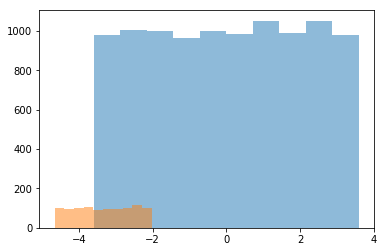

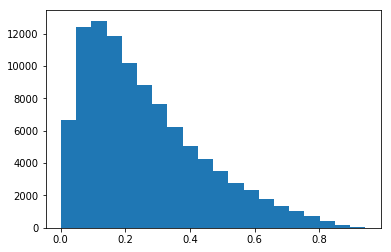

(1000, 100)
1000 100
100000 25981.1165531
0.259811165531
[ 0.04637528  0.03542032  0.04513926 ...,  0.03201415  0.04195623
  0.03935565]
--- -
[]


In [6]:
# n_factors, a0, a1, min_active, max_active = (5, 9, 1, 1, 3)
# n_factors, a0, a1, min_active, max_active = (100, 0, 1, 1, 5)
# n_factors, a0, a1, min_active, max_active = (1, 0, 0.33, 1, 1)
# n_students = 100
# n_questions = 25

n_factors, min_active, max_active = (10,10,10)
n_students, n_questions, a0, a1, offset, test_w =(1000, 100, 0.8110750422323121, 1.1967074599870124, 0.53204746933021974, 2.6389781733222257)

# n_factors, min_active, max_active = (10, 1, 5)
# n_students, n_questions, a0, a1, offset, test_w =(1000, 100, 1.0451284704587152, 1.4855458602659655, 0.53204746933021974, 2.0764586353304395)

# res =gen_run(n_factors, n_students, n_questions, a0, sda, min_active, max_active, None,None)
obs, probz, students, questions  = gen_run(n_factors, a0, a1, min_active, max_active, test_w = test_w)
# print(len(res))

plt.hist(students.flatten(), alpha=0.5)
# plt.show()
plt.hist(questions.flatten(), alpha=0.5)
plt.show()
# print(numpy.mean(questions[questions>0]))

plt.hist(probz.flatten(), bins=20)

plt.show()

print(probz.shape)
print(len(students), len(questions))

print(len(obs.flatten()), sum(obs.flatten()))
print(sum(obs.flatten())/len(obs.flatten()))

print(probz[probz<0.05])
print("--- -")
print(probz[probz>0.95])



2 1.1967074599870124
~ ~ ~ ~~ ATTEMPT 0


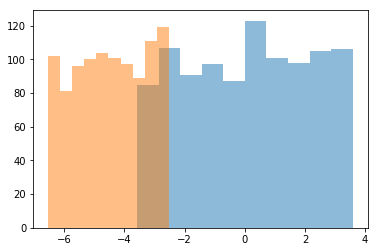

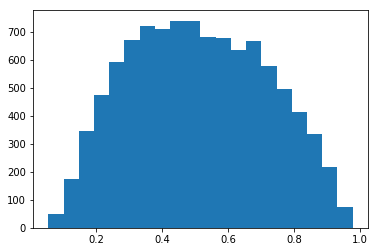

10 FACTORS
100 STUDENTS: 2 1.1967074599870124
100 QUEST/NS: 4
Offset 0.5320474693302197
(100, 100, 2.0, 1.1967074599870124, 0.5320474693302197, 4)
pred list shape (0,)
real items shape (100, 10)


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide


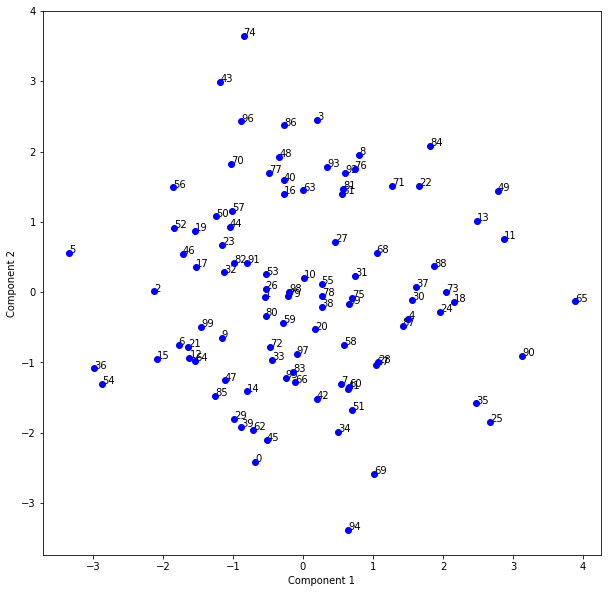

len Cs 0
Mean rand score = nan nan
2 1.1967074599870124
~ ~ ~ ~~ ATTEMPT 1


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


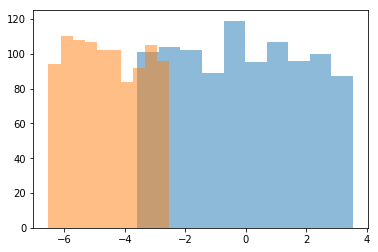

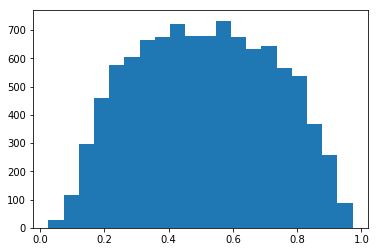

10 FACTORS
100 STUDENTS: 2 1.1967074599870124
100 QUEST/NS: 4
Offset 0.5320474693302197
(100, 100, 2.0, 1.1967074599870124, 0.5320474693302197, 4)
pred list shape (0,)
real items shape (100, 10)


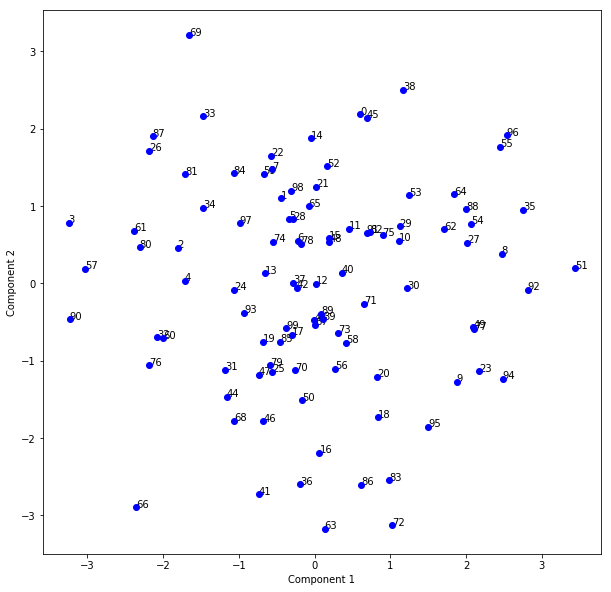

len Cs 0
Mean rand score = nan nan
2 1.1967074599870124
~ ~ ~ ~~ ATTEMPT 2


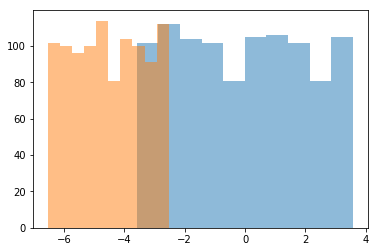

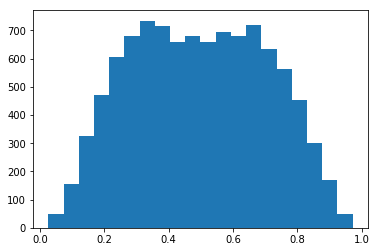

10 FACTORS
100 STUDENTS: 2 1.1967074599870124
100 QUEST/NS: 4
Offset 0.5320474693302197
(100, 100, 2.0, 1.1967074599870124, 0.5320474693302197, 4)
pred list shape (0,)
real items shape (100, 10)


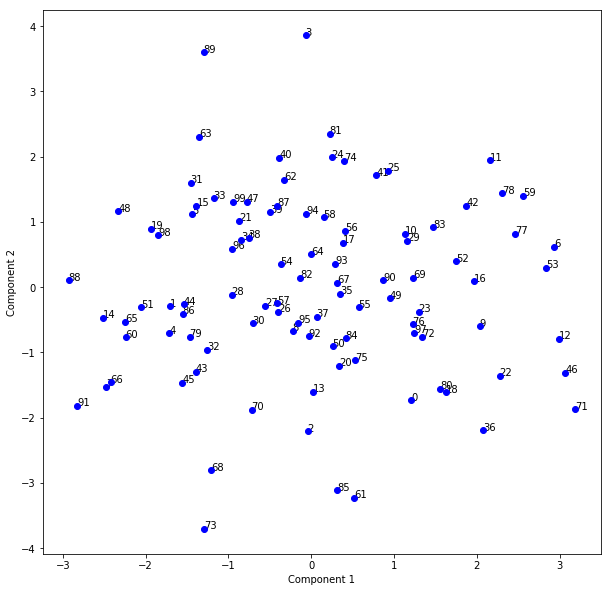

len Cs 0
Mean rand score = nan nan
2 1.1967074599870124
~ ~ ~ ~~ ATTEMPT 3


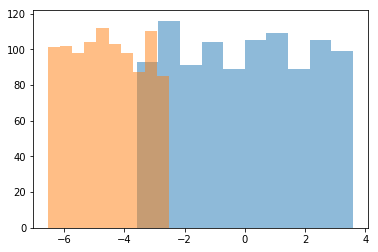

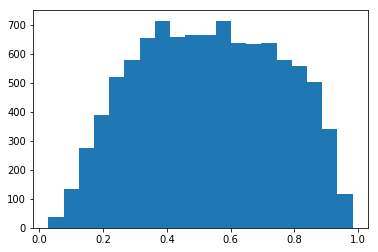

10 FACTORS
100 STUDENTS: 2 1.1967074599870124
100 QUEST/NS: 4
Offset 0.5320474693302197
(100, 100, 2.0, 1.1967074599870124, 0.5320474693302197, 4)
pred list shape (0,)
real items shape (100, 10)


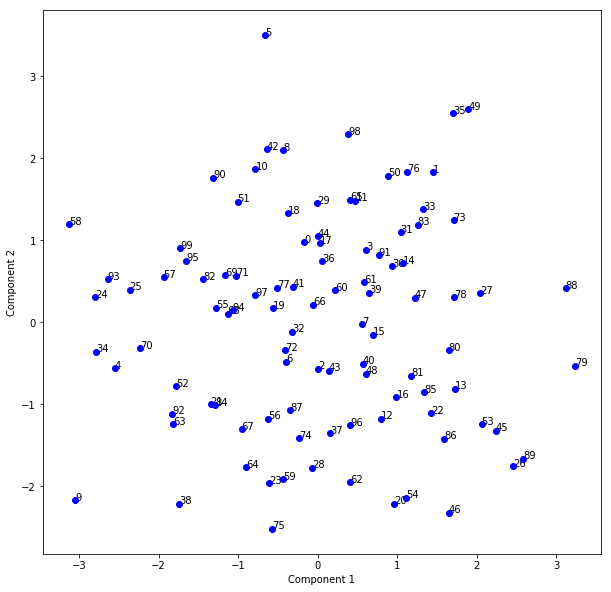

len Cs 0
Mean rand score = nan nan
2 1.1967074599870124
~ ~ ~ ~~ ATTEMPT 4


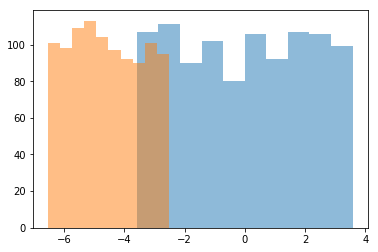

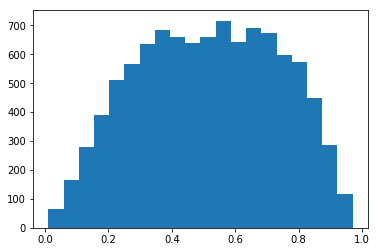

10 FACTORS
100 STUDENTS: 2 1.1967074599870124
100 QUEST/NS: 4
Offset 0.5320474693302197
(100, 100, 2.0, 1.1967074599870124, 0.5320474693302197, 4)
pred list shape (0,)
real items shape (100, 10)


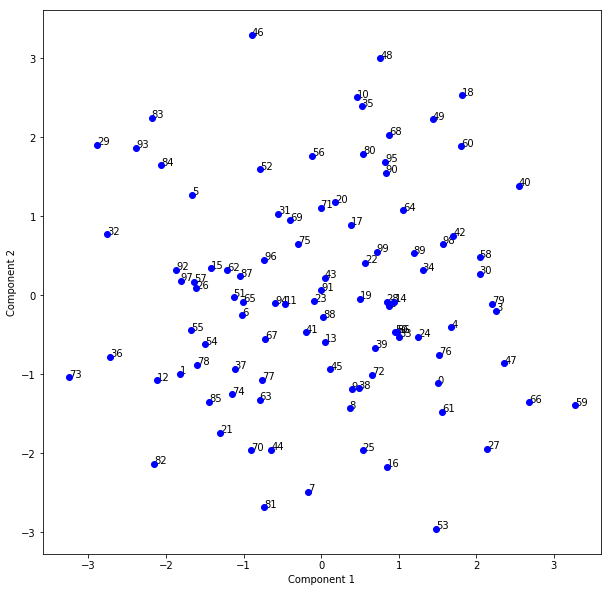

len Cs 0
Mean rand score = nan nan
2 1.1967074599870124
~ ~ ~ ~~ ATTEMPT 5


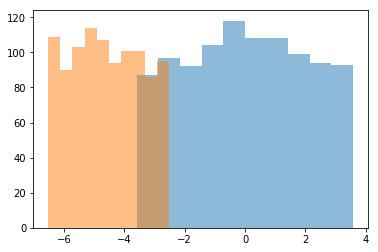

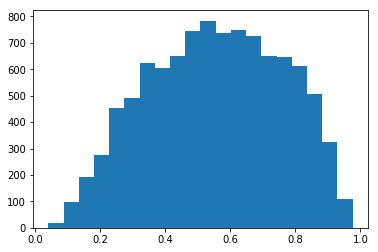

10 FACTORS
100 STUDENTS: 2 1.1967074599870124
100 QUEST/NS: 4
Offset 0.5320474693302197
(100, 100, 2.0, 1.1967074599870124, 0.5320474693302197, 4)
pred list shape (0,)
real items shape (100, 10)


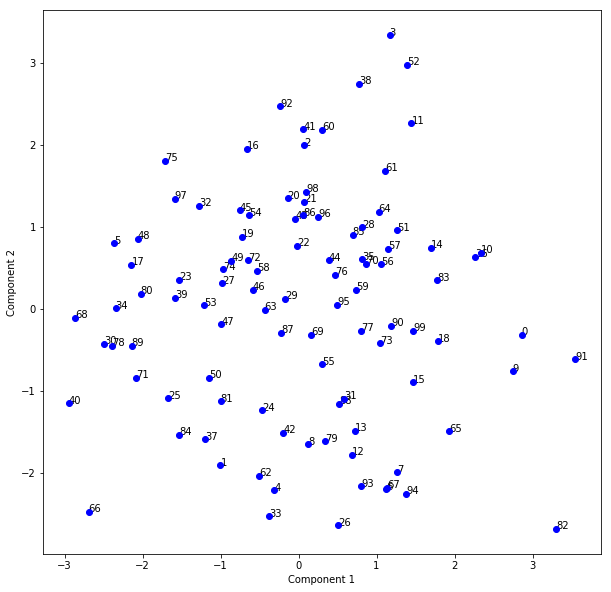

len Cs 0
Mean rand score = nan nan
2 1.1967074599870124
~ ~ ~ ~~ ATTEMPT 6


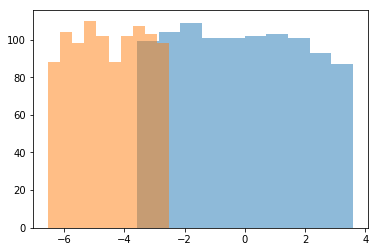

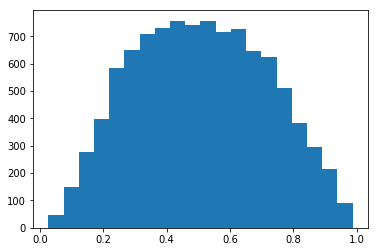

10 FACTORS
100 STUDENTS: 2 1.1967074599870124
100 QUEST/NS: 4
Offset 0.5320474693302197
(100, 100, 2.0, 1.1967074599870124, 0.5320474693302197, 4)
pred list shape (0,)
real items shape (100, 10)


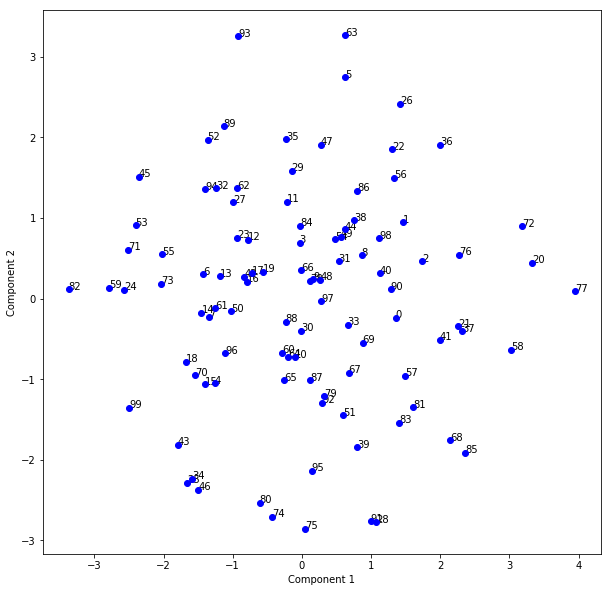

len Cs 0
Mean rand score = nan nan
2 1.1967074599870124
~ ~ ~ ~~ ATTEMPT 7


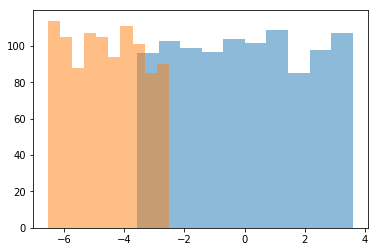

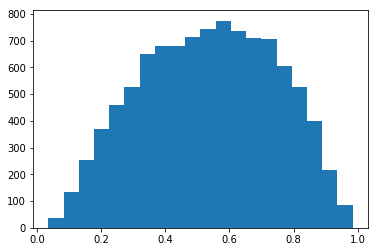

10 FACTORS
100 STUDENTS: 2 1.1967074599870124
100 QUEST/NS: 4
Offset 0.5320474693302197
(100, 100, 2.0, 1.1967074599870124, 0.5320474693302197, 4)
pred list shape (0,)
real items shape (100, 10)


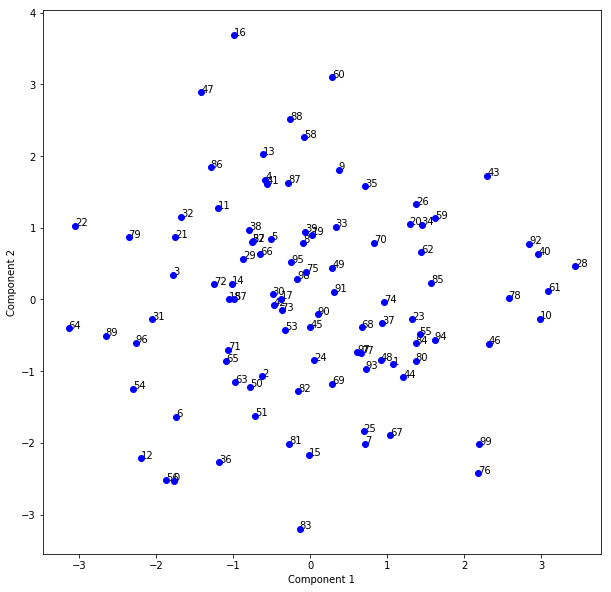

len Cs 0
Mean rand score = nan nan
2 1.1967074599870124
~ ~ ~ ~~ ATTEMPT 8


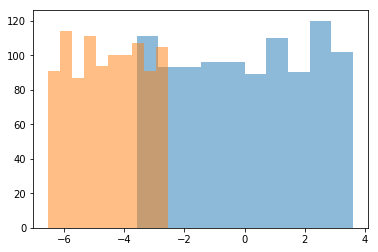

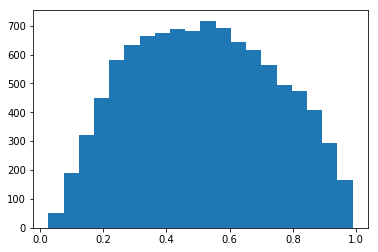

10 FACTORS
100 STUDENTS: 2 1.1967074599870124
100 QUEST/NS: 4
Offset 0.5320474693302197
(100, 100, 2.0, 1.1967074599870124, 0.5320474693302197, 4)
pred list shape (0,)
real items shape (100, 10)


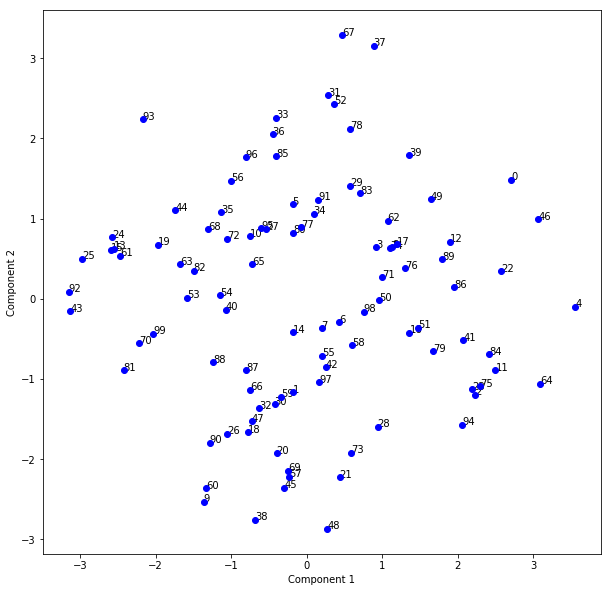

len Cs 0
Mean rand score = nan nan
2 1.1967074599870124
~ ~ ~ ~~ ATTEMPT 9


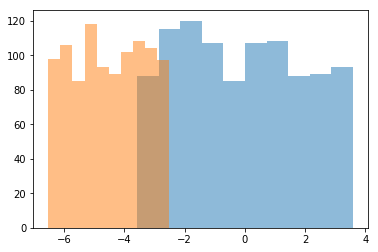

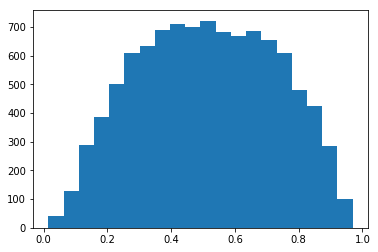

10 FACTORS
100 STUDENTS: 2 1.1967074599870124
100 QUEST/NS: 4
Offset 0.5320474693302197
(100, 100, 2.0, 1.1967074599870124, 0.5320474693302197, 4)
pred list shape (0,)
real items shape (100, 10)


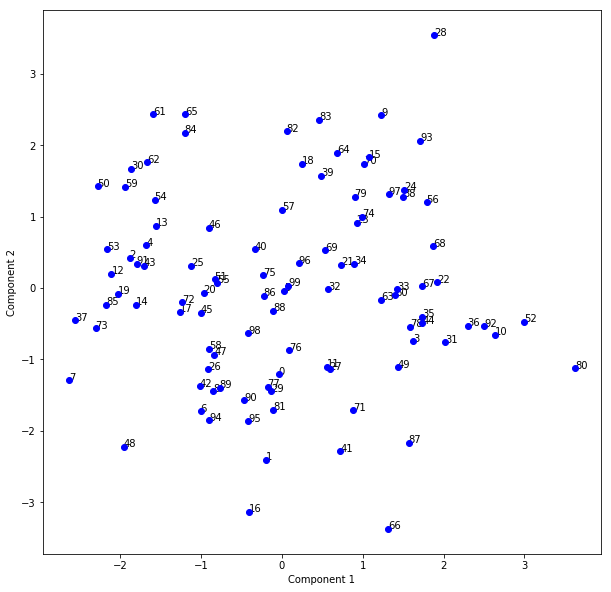

len Cs 0
Mean rand score = nan nan


In [32]:
# n_factors, a0, a1, min_active, max_active = (5, 9, 1, 1, 3)
# n_factors, a0, a1, min_active, max_active = (100, 0, 1, 1, 5)
n_factors, min_active, max_active = (10,10,10)

for a in range(10):
    n_students = 100 # int(10**(scipy.stats.truncnorm.rvs(2,4, size=1)))
    n_questions = 100 # int(numpy.random.uniform(15,35, size=1))

#     a1,a0,av_c,offset,test_w = generate_params(max_active, min_active)
    _,_, a0, a1, offset, test_w =(1000, 100, 0.8110750422323121, 1.1967074599870124, 0.53204746933021974, 2.6389781733222257)

    test_w = 4
    a0 = 2
    
    print(a0, a1)
    obs, probz, students, questions  = gen_run(n_factors, a0, a1, min_active, max_active, test_w = test_w)

    print("~ ~ ~ ~~ ATTEMPT",a)
    plt.hist(students.flatten(), alpha=0.5)
    plt.hist(questions.flatten(), alpha=0.5)
    plt.show()
    plt.hist(probz.flatten(), bins=20)
    plt.show()
    print("{} FACTORS".format(n_factors))
    print("{} STUDENTS: {} {}".format(n_students, a0, a1))
    print("{} QUEST/NS: {}".format(n_questions, test_w))
    print("Offset", offset)
    print((n_students, n_questions, float(a0), float(a1), offset, test_w))
    
    plot_items([], questions+5, None)
    

In [ ]:
# for orow in obs:
#     srow = map(str, map(int, list(orow)))
#     srow = "".join(srow)
#     print(srow)

In [ ]:
# students = gen_students(100, 9, 1, 100)
# questions, minval = gen_questions(100, 9, 1, 1,5, gen_mode="uniform")
# # plt.hist(questions.flatten())
# print(minval)
# q2 = questions
# q2[q2>0] = q2[q2>0] - minval +6
# s2 = students - minval +6
# plt.hist(q2.flatten(), alpha=0.5)
# plt.hist(s2.flatten(), alpha=0.5)

# plt.show()

In [ ]:
# from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout, dot
# from keras import backend as K
# from keras.optimizers import Adam
# def generate_mxf_model(qn_table, psi_table, optimiser, comp_lims=True, q_train=True, s_train=True):
#     psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
#     qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
# #     ob = Input(shape=(1,), name="observation")
#     print(qn_table, psi_table, psi_sel, qn_sel)
#     print("psi_sel shape", psi_sel.shape)

#     psi_table.trainable=s_train
#     qn_table.trainable=q_train
    
#     qn_row = qn_table(qn_sel)
#     psi_row = psi_table(psi_sel)
#     score = dot([psi_row, qn_row], axes=1)
    
#     mag_loss=0
    
#     def custom_loss(mag_loss):
#         def orig_loss(yt,yh):
# #             return K.binary_crossentropy(yt,yh) + mag_loss/100000 #+mag_loss # (reg_loss+mag_loss)/2
# #             if comp_lims:
#             return K.mean(K.square(yt-yh)) #+ mag_loss #+mag_loss # (reg_loss+mag_loss)/2
# #                 return K.binary_crossentropy(yt,yh) #+ mag_loss/1000 #+mag_loss # (reg_loss+mag_loss)/2
# #             else:
# # #                 return K.mean(K.square(yt-yh))
# #                 return K.binary_crossentropy(yt,yh)
#         return orig_loss
    
#     model = Model(inputs=[qn_sel, psi_sel], outputs=score)
# #     model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])
# #     if comp_lims:
#     model.compile(optimizer=optimiser, loss=custom_loss(mag_loss), metrics=["accuracy"])# metrics=[ident_loss(five_loss), ident_loss(one_loss),"accuracy"])
# #     else:
# #     model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])
        
#     print(model.summary())

#     return model

In [ ]:
# print(len(students))
# print(len(questions))

In [535]:
# def tvt_split(sws, qws, split_mode=3):
#     all_sz = []
#     all_qz = []
#     all_pfz = []
#     sig = lambda z : 1/(1+numpy.exp(-z))
#     obs = numpy.zeros((len(sws), len(qws)))
#     probs = numpy.zeros((len(sws), len(qws)))
#     #obs = numpy.matmul(viewers, movies.T)/n_factors
#     vz = []
#     mz = []
#     scz =[]
#     all_pfz=[]
#     all_pairs = set()
#     attempt_lookup = defaultdict(list)
#     cts=[]
#     for vi in range(len(sws)):
#         for mi in range(len(qws)):
#             for _ in range(1):
#                 all_pairs.add((vi,mi))
# #                 zmask = (qws[mi]==-10).astype(int)
#                 deltas = sws[vi]-qws[mi]
#                 prs = logistic(deltas,1,0)
# #                 prs = numpy.maximum(zmask,prs)

#                 pr = numpy.prod(prs)
#                 ct=0

#                 all_sz.append(vi)
#                 all_qz.append(mi)

#                 rd = random.random()
# #                     print(vi, mi, pr, rd)
#                 ob = (rd < pr)
# #                 obs[vi,mi] = ob
#                 probs[vi,mi] = pr
# #                 all_pfz.append(pr)
#                 attempt_lookup[(vi,mi)].append(ob)
#     #             print(vi,mi, numpy.prod(prs))

#     print("len all_pfz", len(all_pfz))
#     plt.hist(all_pfz)
#     plt.show()

#     plt.hist(probs.flatten())
#     plt.show()
    
#     plt.hist(cts, range=[0,10])
#     plt.show()

#     print("OBS SSHAPE", obs.shape)

#     frak=1
#     all_pair_ixs = list(range(len(all_pairs)))
#     # ixs_to_use = numpy.random.choice(all_pair_ixs, size=int(max(frak*len(all_pairs),10)), replace=True)
#     # pairs_to_use = numpy.array(all_pairs)[ixs_to_use]

#     all_ixs = all_pair_ixs
    
#     val_ixs = numpy.random.choice(all_pair_ixs, size=1000, replace=False) #len(attempts)//100, replace=False)
#     trn_ixs = list(set(all_ixs) - set(val_ixs))
#     test_ixs = numpy.random.choice(trn_ixs, size=1000, replace=False) #len(attempts)//100, replace=False)
#     trn_ixs = list(set(trn_ixs) - set(test_ixs))
#     print("tvt:", len(all_ixs), len(trn_ixs), len(test_ixs))

# #     all_sz = numpy.array(all_sz).reshape([-1,1])
# #     all_qz = numpy.array(all_qz).reshape([-1,1])
# #     all_pfz = numpy.array(all_pfz).reshape([-1,1])
# #     print("len all_pfz", len(all_pfz))

#     all_pairs = sorted(list(all_pairs))
#     test_pairs = [all_pairs[ix] for ix in test_ixs]
#     val_pairs = [all_pairs[ix] for ix in val_ixs]
#     train_pairs = [all_pairs[ix] for ix in trn_ixs]
    
#     tsz=[]
#     tqz=[]
#     tpfz=[]
    
#     vsz=[]
#     vqz=[]
#     vpfz=[]
    
#     sz=[]
#     qz=[]
#     pfz=[]
    
#     for tp in test_pairs:
#         scores = attempt_lookup[tp]
#         for sc in scores:
#             tsz.append(tp[0])
#             tqz.append(tp[1])
#             tpfz.append(sc)
    
#     if split_mode==2:
#         train_pairs = train_pairs + val_pairs
#         val_pairs = []
    
#     if split_mode==1:
#         train_pairs = train_pairs + val_pairs + test_pairs
#         test_pairs = []
#         val_pairs = []
    
#     for tp in val_pairs:
#         scores = attempt_lookup[tp]
#         for sc in scores:
#             vsz.append(tp[0])
#             vqz.append(tp[1])
#             vpfz.append(sc)

#     for tp in train_pairs:
#         scores = attempt_lookup[tp]
#         for sc in scores:
#             sz.append(tp[0])
#             qz.append(tp[1])
#             pfz.append(sc)

#     tsz=numpy.array(tsz)
#     tqz=numpy.array(tqz)
#     tpfz=numpy.array(tpfz)
    
#     vsz=numpy.array(vsz)
#     vqz=numpy.array(vqz)
#     vpfz=numpy.array(vpfz)
    
#     sz=numpy.array(sz)
#     qz=numpy.array(qz)
#     pfz=numpy.array(pfz)
    
#     return (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz), obs, probs

len all_pfz 0


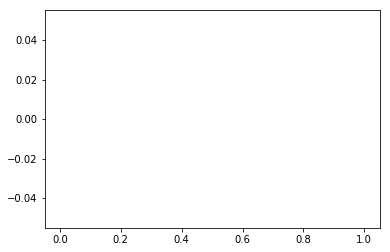

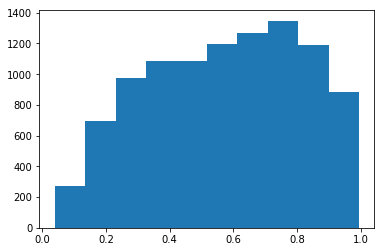

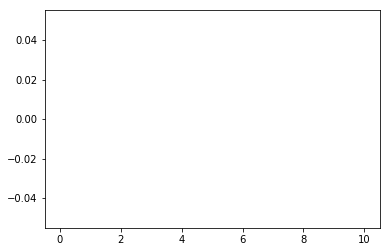

OBS SSHAPE (100, 100)
tvt: 10000 8000 1000
[False  True  True False False False False  True  True  True  True  True
 False  True  True  True  True False  True  True  True False  True False
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True False  True False  True False  True  True  True  True
 False False False  True  True False False False False  True False False
 False False  True False  True  True  True False  True False False False
  True  True  True  True  True  True False  True False  True False False
  True  True  True False  True False  True False  True False False  True
 False  True  True  True  True  True  True False  True False  True False
  True False False False  True False  True False False  True False  True
  True False  True  True  True False False  True False  True  True False
 False False  True  True  True False False  True False False  True False
 False  True  True  True False  True False  True False  True False False
 False  

In [103]:
(sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz), obs, probs = tvt_split(students, questions)
print(vpfz)

In [ ]:
# print(obs.shape)
# rho_mx = numpy.corrcoef(obs.T, obs.T)
# print(rho_mx)
# print(rho_mx.shape)

In [ ]:
# import sklearn
# rho_mx2 = sklearn.metrics.pairwise.cosine_similarity(obs.T,obs.T)
# numpy.set_printoptions(threshold=100)
# print(rho_mx2)
# print(rho_mx2.shape)

In [ ]:
# user_index = 500 # The id of the user for whom we want to generate recommendations

# # magnitude = numpy.sqrt(numpy.square(obs).sum(axis=1))

# # unitvector = (x / magnitude, y / magnitude, z / magnitude, ...)
# # data_items = obs / magnitude.reshape(-1,1)
# data_items = obs

# # Get the artists the user has likd.
# for user_index in range(len(students)):
#     known_user_likes = data_items[user_index,:]
# #     print(known_user_likes)
#     # known_user_likes = known_user_likes[known_user_likes >0].index.values
#     # known_user_likes = numpy.argwhere(known_user_likes)

# #     print(rho_mx2.sum(axis=0))

#     # Calculate the score.
# #     score = rho_mx2.dot(known_user_likes) / (rho_mx2.sum(axis=0))

#     for i in range(len(questions)):
#         sum_nom=0
#         sum_denom=0
#         wi = rho_mx2[i]
#         rui = data_items[user_index, i]
#         for j in range(len(questions)):
#             wij = wi[j]
#             sum_nom += wij*rui
#             sum_denom += abs(wij)
#         score = sum_nom/sum_denom
#         numpy.set_printoptions(precision=5)
#         print(user_index, i, score)
# #         print(students[user_index])
#     # Remove the known likes from the recommendation.
#     # score = numpy.delete(score, known_user_likes)

#     # Print the known likes and the top 20 recommendations.

#     # print (score.argsort()[::-1][:20])
    

In [ ]:
# for ix in range(len(qws)):
#     flags = (qws[ix]>1).astype(int) 
#     print(flags, sum(flags))
# # print((qws>=1).astype(int))

In [ ]:
numpy.set_printoptions(precision=2)
for vi,mi,sc in zip(sz,qz,pfz):
    print(vi,mi,sc)

In [ ]:
print("TRUE VALS")
# print(numpy.min(questions), numpy.min(questions[questions.nonzero()]), numpy.max(questions))
print(numpy.min(questions), numpy.max(questions))
print(numpy.min(students), numpy.max(students))
print("--- EMB VALS (prior):")
qws = qn_table.get_weights()[0]
sws = s_table.get_weights()[0]
# print(numpy.min(qws), numpy.min(qws[qws>=1]), numpy.max(qn_table.get_weights()[0]))
print(numpy.min(qws), numpy.max(qn_table.get_weights()[0]))
print(numpy.min(s_table.get_weights()[0]), numpy.max(s_table.get_weights()[0]))


# print(qws)

In [ ]:
print(qz)

preds = m.predict(x=[qz,sz])
for sc_true, sc_hat in zip(pfz[0:100],preds[0:100]):
    print(sc_true, sc_hat)

# print(m.evaluate(x=[mz,vz], y=scz))
from sklearn.metrics import accuracy_score, mean_absolute_error
print(accuracy_score(numpy.around(pfz), numpy.around(preds)  ))

s_scores = defaultdict(list)

for six in range(len(students)):
    scs = m.predict(x=[numpy.array(range(len(questions))).reshape(-1,1), numpy.array(six).repeat(len(questions))])
    s_scores[six].extend(scs)

for six in range(len(students)):
    s_av = float(numpy.median(s_scores[six]))
    print(six, s_av)


In [7]:
# wz = m.get_weights()
# s_table =  BigTable((n_students, n_factors), 6, 100, init_hilo=10)#, regulariser=regularizers.l1(10e-6))
# qn_table = BigTable((n_questions, n_factors), 0, 100, init_hilo=10-p50)#, regulariser=regularizers.l1(10e-6))
# qm = generate_qs_model(qn_table, s_table, Adam(), comp_lims=False, s_train=False, q_train=True)
# sm = generate_qs_model(qn_table, s_table, Adam(), comp_lims=False, s_train=True, q_train=False)
from keras import regularizers
def generate_and_train(qz,sz,pfz, vqz,vsz,vpfz, w=n_factors, qn_av=None, qn_std=None):
    weight_mode="free"
#     weight_mode="bayesian"
# #     numpy.random.seed(666)
    if weight_mode=="free":
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo=0.1)#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo=0.1)#, regulariser=regularizers.l1(10e-6))
    elif weight_mode=="semi-free":
        s_table =  BigTable((n_students, w), -3, 3, init_hilo=0.1)#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo=0.1)#, regulariser=regularizers.l1(1e-6))
    elif weight_mode=="bayesian":
        s_table =  BigTable((n_students, w), 0, 1, init_hilo=0.5)#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), 0, 1, init_hilo=0.5)#, regulariser=regularizers.l1(1e-6))
    else:
        s_table =  BigTable((n_students, w), 0, 12, init_hilo=0)#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), 0, 12, init_hilo=0)#, regulariser=regularizers.l1(10e-6))
    from keras.layers import Embedding
    from keras.constraints import NonNeg, MinMaxNorm
    from keras.initializers import RandomNormal, RandomUniform
    
#     wc=WeightClip(0,1)
    
    q_gates = None #Embedding(n_questions,w, input_length=1, embeddings_initializer=RandomUniform(minval=0, maxval=1, seed=None), embeddings_constraint=wc)
#     qn_table = Embedding(n_questions,w, input_length=1, embeddings_initializer=RandomNormal(mean=6, stddev=0.3))
#     s_table = Embedding(n_students,w, input_length=1, embeddings_constraint=WeightClip(0,math.inf), embeddings_initializer=RandomNormal(mean=6, stddev=0.3))
    
    m = generate_qs_model(qn_table, s_table, Adam(), comp_lims=False, qn_av=qn_av, qn_std=qn_std)#, s_train=True, q_train=True)
#     if vpfz is None:
#         lozz="loss"
#     else:
#         lozz="val_loss"
    es = EarlyStopping(monitor="loss", restore_best_weights=True, patience=10)
    h = m.fit(x=[qz,sz], y=numpy.array(pfz).reshape(-1,1), batch_size=1000, shuffle=True, epochs=100000, verbose=1, callbacks=[es])#, validation_data=[[vqz,vsz], vpfz])
    return s_table, qn_table, q_gates, m, h

In [422]:
s_table, qn_table, _, m, h = generate_and_train(qz,sz,pfz, vqz,vsz,vpfz, w=n_factors)

<NN_utils.BigTable object at 0x7f6bfde7b080> <NN_utils.BigTable object at 0x7f6bfde77fd0> Tensor("psi_select_204:0", shape=(?, 1), dtype=int32) Tensor("q_select_204:0", shape=(?, 1), dtype=int32)
psi_sel shape (?, 1)
kk (1000, 10)
selector shape (?, 1)
flat selector shape (?,)
call kk (1000, 10)
'rows' shape, (?, 10)
kk (100, 10)
selector shape (?, 1)
flat selector shape (?,)
call kk (100, 10)
'rows' shape, (?, 10)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
psi_select (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
q_select (InputLayer)           (None, 1)            0                                            
______________________________________________________________________________________

100000/100000 [==============================] - 1s 5us/step - loss: 0.5950 - acc: 0.6811
Epoch 135/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5950 - acc: 0.6812
Epoch 136/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5949 - acc: 0.6811
Epoch 137/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5949 - acc: 0.6810
Epoch 138/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5948 - acc: 0.6810
Epoch 139/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5948 - acc: 0.6811
Epoch 140/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5948 - acc: 0.6815
Epoch 141/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5947 - acc: 0.6814
Epoch 142/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5947 - acc: 0.6811
Epoch 143/1000
100000/100000 [==============================] - 1s 5us

100000/100000 [==============================] - 1s 5us/step - loss: 0.5465 - acc: 0.7212
Epoch 291/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5461 - acc: 0.7214
Epoch 292/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5458 - acc: 0.7218
Epoch 293/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5454 - acc: 0.7222
Epoch 294/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5451 - acc: 0.7223
Epoch 295/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5448 - acc: 0.7225
Epoch 296/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5444 - acc: 0.7229
Epoch 297/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5441 - acc: 0.7231
Epoch 298/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5438 - acc: 0.7233
Epoch 299/1000
100000/100000 [==============================] - 1s 5us

100000/100000 [==============================] - 1s 5us/step - loss: 0.5200 - acc: 0.7397
Epoch 447/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5199 - acc: 0.7396
Epoch 448/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5198 - acc: 0.7398
Epoch 449/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5198 - acc: 0.7397
Epoch 450/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5197 - acc: 0.7400
Epoch 451/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5196 - acc: 0.7400
Epoch 452/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5195 - acc: 0.7400
Epoch 453/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5195 - acc: 0.7401
Epoch 454/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5194 - acc: 0.7402
Epoch 455/1000
100000/100000 [==============================] - 1s 5us

100000/100000 [==============================] - 1s 5us/step - loss: 0.5127 - acc: 0.7437
Epoch 603/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5127 - acc: 0.7435
Epoch 604/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5126 - acc: 0.7436
Epoch 605/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5126 - acc: 0.7436
Epoch 606/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5126 - acc: 0.7436
Epoch 607/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5125 - acc: 0.7437
Epoch 608/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5125 - acc: 0.7435
Epoch 609/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5125 - acc: 0.7437
Epoch 610/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5125 - acc: 0.7440
Epoch 611/1000
100000/100000 [==============================] - 1s 5us

100000/100000 [==============================] - 1s 6us/step - loss: 0.5092 - acc: 0.7471
Epoch 759/1000
100000/100000 [==============================] - 1s 6us/step - loss: 0.5092 - acc: 0.7472
Epoch 760/1000
100000/100000 [==============================] - 1s 6us/step - loss: 0.5091 - acc: 0.7473
Epoch 761/1000
100000/100000 [==============================] - 0s 5us/step - loss: 0.5091 - acc: 0.7473
Epoch 762/1000
100000/100000 [==============================] - 1s 5us/step - loss: 0.5091 - acc: 0.7471
Epoch 763/1000
100000/100000 [==============================] - 0s 5us/step - loss: 0.5091 - acc: 0.7473
Epoch 764/1000
100000/100000 [==============================] - 0s 5us/step - loss: 0.5091 - acc: 0.7473
Epoch 765/1000
100000/100000 [==============================] - 1s 6us/step - loss: 0.5091 - acc: 0.7472
Epoch 766/1000
100000/100000 [==============================] - 1s 6us/step - loss: 0.5090 - acc: 0.7473
Epoch 767/1000
100000/100000 [==============================] - 1s 5us

100000/100000 [==============================] - 1s 5us/step - loss: 0.5070 - acc: 0.7494
Epoch 915/1000
100000/100000 [==============================] - 0s 5us/step - loss: 0.5070 - acc: 0.7495
Epoch 916/1000
100000/100000 [==============================] - 0s 5us/step - loss: 0.5070 - acc: 0.7495
Epoch 917/1000
100000/100000 [==============================] - 0s 5us/step - loss: 0.5070 - acc: 0.7495
Epoch 918/1000
100000/100000 [==============================] - 0s 5us/step - loss: 0.5069 - acc: 0.7493
Epoch 919/1000
100000/100000 [==============================] - 0s 5us/step - loss: 0.5069 - acc: 0.7496
Epoch 920/1000
100000/100000 [==============================] - 0s 5us/step - loss: 0.5069 - acc: 0.7494
Epoch 921/1000
100000/100000 [==============================] - 0s 5us/step - loss: 0.5069 - acc: 0.7494
Epoch 922/1000
100000/100000 [==============================] - 0s 5us/step - loss: 0.5069 - acc: 0.7495
Epoch 923/1000
100000/100000 [==============================] - 0s 5us

In [87]:
for six in range(len(students)):
    print("S=",six)
    scs = m.predict(x=[numpy.array(range(len(questions))).reshape(-1,1), numpy.array(six).repeat(len(questions))])
    for qix in range(len(questions)):
        print(qix, " : ", scs[qix], obs[six,qix], probs[six,qix])
#     s_scores[six].extend(scs)

# for six in range(len(students)):
#     s_av = float(numpy.median(s_scores[six]))
#     print(six, s_av)
    
    
    

S= 0


NameError: name 'probs' is not defined

In [ ]:
def plot_history(history):
    plt.plot(history.history['acc'])
#     plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('MSE loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(h)

In [ ]:
right_ct=0
# preds = m.predict(x=[qz,sz])
# for q,s, sc_obsv, sc_hat in zip(qz,sz,pfz,preds):
#     print(q,s, sc_obsv, sc_hat, "right" if (numpy.around(sc_obsv)==numpy.around(sc_hat)) else "X")

print(len(pfz), len(tpfz))
right_ct=0
preds = m.predict(x=[tqz,tsz]).flatten()
print(preds)
# flags = numpy.random.random(size=len(preds))
# print(flags)
# preds = flags <= preds
ground_truths = []
zipd_list = sorted(list(zip(tsz, tqz,tpfz,preds)))
for s,q, sc_obsv, sc_hat in zipd_list:
#     sc_hat_stoc = (random.random() < sc_hat)
    pr = probs[s,q]
    print(q,s, sc_obsv, pr, sc_hat, "right" if (numpy.around(pr)==numpy.around(sc_hat)) else "X")
    ground_truths.append((pr,sc_hat))
#     print(sc_obsv, sc_hat, res)

# print(m.evaluate(x=[tmz,tvz], y=tscz))

from sklearn.metrics import accuracy_score, mean_absolute_error
print(preds.shape)

# print(right_ct / len(tpfz))

print("#########")
for (g,p) in ground_truths:
    print(g,p)

print("obvsd acc", accuracy_score(numpy.around([g[0] for g in ground_truths]), numpy.around([g[1] for g in ground_truths])))
# print("non-stoch acc", accuracy_score(numpy.around(t_probz), numpy.around(preds)))
# print(mean_absolute_error(t_probz, preds))
#0.000302638761699 MSE MxMul


In [ ]:
for qix in range(len(questions)):
    kcs = numpy.argwhere(questions[qix] > 1)
    
    klevs = questions[qix][kcs.flatten()] 
    print(qix, ["{}={}".format(k,round(klev,2)) for (k,klev) in zip(kcs.flatten(),klevs)])

In [ ]:
qws = qn_table.get_weights()[0]
sws = s_table.get_weights()[0]
# qmin = min(qws)

offset = numpy.mean(students) - numpy.mean(sws) 
qws = qws #+ offset
sws = sws #S+ offset
print(len(qws.flatten()))
print(len(questions.flatten()))
item_RMSE = numpy.sqrt(numpy.mean(numpy.square(numpy.sort(qws.flatten()) - numpy.sort(questions.flatten()))))
item_MAE = numpy.mean(numpy.abs(numpy.sort(qws.flatten()) - numpy.sort(questions.flatten())))
# item_RMSE = numpy.sqrt(numpy.mean(numpy.square(qws.flatten() - questions.flatten())))
# item_MAE = numpy.mean(numpy.abs(qws.flatten() - questions.flatten()))

print(item_RMSE, item_MAE)

In [8]:
# preds = m.predict([tqz,tsz])
# for pred,q,s in zip(preds,tqz,tsz):
#     print(q, pred)
numpy.set_printoptions(precision=2)

seen = set()
for qix,six in zip(tqz, tsz):
    if (int(qix),int(six)) in seen:
        continue
    else:
        seen.add((int(qix),int(six)))
    qrow = questions[qix].flatten()
    srow = students[six].flatten()
    qhat = qws[qix].flatten()
    shat = sws[six].flatten()
#     print(qix, six, (srow, shat), (qrow, qhat), srow-qrow, shat-qhat)
    print("STUDENT", six)
    print(srow)
    print(shat)
    print("VS Q", qix)
    print(qrow)
    print(qhat)#, " >>>", srow-qrow, shat-qhat)
    print("Comp. Prs:")
    for s,q in ((srow,qrow), (shat,qhat)):
        zmask = (q<0.0001).astype(int)
        deltas = s-q
        prs = logistic(deltas,1,0)
        prs = numpy.maximum(zmask,prs)
        print(prs, numpy.prod(prs))
    
print(len(sws))
print(len(students))

bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

plt.hist(students.flatten(), alpha=0.5, bins=bin_spread(students))
plt.hist(sws[list(set(tsz))].flatten(), alpha=0.4, bins=bin_spread(sws))
plt.show()
plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
print(bin_spread(qws))
plt.hist(qws[list(set(tqz))].flatten(), alpha=0.4, bins=bin_spread(qws))
plt.show()

NameError: name 'tqz' is not defined

In [9]:
def calc_arr_arr_err(split, real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    print(split, real_wgts, pred_wgts, max_iter)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None
    curr_real_ix = None
    
    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    pred_col = pred_col #* pred_q_col
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    
                    if err < curr_err:
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = 0#cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = numpy.array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        
        dis = 0
        mean_ll = numpy.mean( out_col_arr - real_wgts )
        if total_err < min_total_err:
            min_total_err = total_err
            total_q_err = numpy.mean(numpy.abs( out_col_arr[0:split] - real_wgts[0:split] ))
            total_s_err = numpy.mean(numpy.abs( out_col_arr[split:] - real_wgts[split:] ))
            best_ll = mean_ll
            chosen = out_col_arr
            best_dis = dis
    return chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_dis


In [10]:
import copy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def plot_items(pred_list, real_items, s_offset):
    if real_items.shape[1]<2:
        print("real_items is only 1 component wide .. needs to be >1 to plot on a PCA graph")
        return None
    elif real_items.shape[1]==2:
        tx=None
    else:
        tx = PCA(n_components=2)
#         tx = TSNE(n_components=2)
    fyrst = True
    Cs = []
    C_labs = []
    pred_list = numpy.array(pred_list)
    print("pred list shape", pred_list.shape)
    print("real items shape", real_items.shape)


    fitted_pred_list = []
#     offset = numpy.median(pred_list[(pred_list>0.1)], axis=0) - numpy.median(real_items[(real_items>0.1)], axis=0)
#     real_mean = numpy.min(real_items[real_items > 0.1])
#     offset = numpy.min(pred_list[pred_list > 0.1]) - real_mean
#     print("real mean", real_mean)
#     print("offset", offset)
    
    m = len(real_items)
    cols = list(range(m))
    shuffle(cols)
    
    xmeans = numpy.zeros(m)
    ymeans = numpy.zeros(m)
    pairs = defaultdict(list)
    iter = 0
    
    cp_real = copy.copy(real_items)
    cp_real[cp_real < 1] = numpy.nan
    r_offset=numpy.nanmedian(cp_real, axis=0)
    
    itemz_2 = real_items
    n = len(real_items)
    
    for opreds in pred_list:
        preds = copy.copy(opreds) #- s_offset[iter] + r_offset
        split = 0
        
        items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_items, preds, max_iter=10)

        itemz_pred = items_chosen
        print(itemz_pred)
#         itemz_pred = numpy.maximum(itemz_pred,0)
        fitted_pred_list.append(itemz_pred)
        
#         itemz = real_items #- offset
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         itemz = numpy.maximum(itemz,0)
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         if itemz_2 is None:
#             itemz_2 = numpy.concatenate([real_itemz, itemz_pred], axis=0)
#         else:
        itemz_2 = numpy.concatenate([itemz_2, itemz_pred], axis=0)

    if tx:
        itemz_2 = tx.fit_transform(itemz_2)
#         itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
#         if fyrst:
#         itemz_2 = tx.fit_transform(itemz_2)
#             fyrst = False
#         else:
#             itemz_2 = tx.transform(itemz_2)

    from sklearn.cluster import KMeans
    iter=0
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    
    for opreds, itemz_pred in zip(pred_list, fitted_pred_list):
        n = len(itemz_pred)
        km = KMeans()
        km.fit(itemz_pred)
        cluster_labels = km.predict(itemz_pred)
        print(cluster_labels)
        
        C = []
        for l in set(cluster_labels):
            cluster = list(numpy.where(cluster_labels==l)[0])
            print("X", cluster)
            C.append(cluster)
        Cs.append(C)
        C_labs.append(cluster_labels)
                
#         NUM_COLORS = 100
#         cm = plt.get_cmap('gist_rainbow')
#         fig.gca().set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
        print(type(itemz_2))
        minix=n*(iter+1)
        maxix=n*(iter+1)+n
        
        #i=0 -> 100,199
        #i=2 -> 200,299
        
        print("no pts=",n," indices=", minix, maxix)
        print("shape of itemz_2", itemz_2.shape)
        fig.gca().scatter(itemz_2[minix:maxix,0], itemz_2[minix:maxix,1], alpha=0.7, c=numpy.array(cols), cmap=plt.get_cmap('nipy_spectral'))
        j=0
        for j in range(n):
            x,xh,y,yh = itemz_2[j+(n*iter),0], itemz_2[j+(n*iter+n) ,0], itemz_2[j+(n*iter),1], itemz_2[j+(n*iter+n),1]
#             fig.gca().plot([x,xh],[y,yh],  color="#aaaaaa80")
            xmeans[j] += xh
            ymeans[j] += yh
            pairs[iter].append((xh, yh))
        iter+=1
        
    for j in range(n):
        fig.gca().annotate(j, (itemz_2[j,0], itemz_2[j,1]))
        
    fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], c="b", zorder=10)
#     fig.gca().axhline(y=1e-6, linestyle="--")
#     fig.gca().axvline(x=1e-6, linestyle="--")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    
    xmeans = xmeans / len(pred_list)
    ymeans = ymeans / len(pred_list)
    

    if len(pred_list)>=1:
        for it in range(len(pred_list)):
            xhyh_pairs = pairs[it]
            for j,hat_pair in enumerate(xhyh_pairs):
                xh,yh = hat_pair
                x,y = itemz_2[j,0], itemz_2[j,1]
                mux = xmeans[j]
                muy = ymeans[j]
#                 fig.gca().scatter(xh, yh, alpha=0.7, c=plt.get_cmap('nipy_spectral')(cols[j]))
#                 fig.gca().scatter(mux,muy, c="#888888ff", marker="*", zorder=10)
#                 fig.gca().plot([mux,xh],[muy,yh],color="#aaaaaa80", linestyle="--")
#                 fig.gca().plot([mux,x],[muy,y],color="#888888dd", linestyle="-")
                fig.gca().plot([x,xh],[y,yh],color="#aaaaaa80", linestyle="--")
        
    plt.show()
    print("len Cs", len(Cs))
    from sklearn.metrics.cluster import adjusted_rand_score
    rands = []
    for ix in range(len(Cs)):
#         print(ix)
        for jx in range(len(Cs)):
#             print(jx)
            if ix!=jx:
#             print(Cs[ix], Cs[jx])
                print("VI:", ix,jx, varinfo(Cs[ix],Cs[jx]))
                a_rand = adjusted_rand_score(C_labs[ix], C_labs[jx])
                print("Rand:", a_rand)
                rands.append(a_rand)
    print("Mean rand score =", numpy.mean(rands), numpy.std(rands))

# qws = qn_table.get_weights()[0]
# qws2 = qn_table2.get_weights()[0]
        
print(len(qws_list))
plot_items(qws_list, copy.copy(questions), s_offset)

NameError: name 'qws_list' is not defined

0.8110750422323121
pred list shape (0,)
real items shape (100, 10)


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide


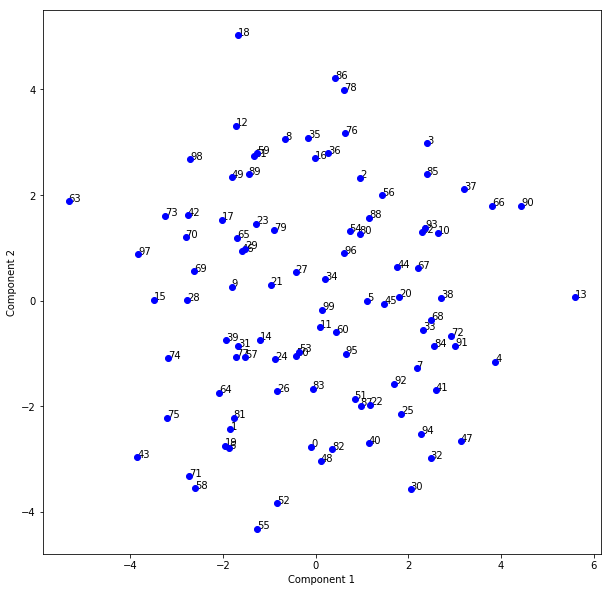

len Cs 0
Mean rand score = nan nan
~ ~ ~ ~~ ATTEMPT 0 4


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


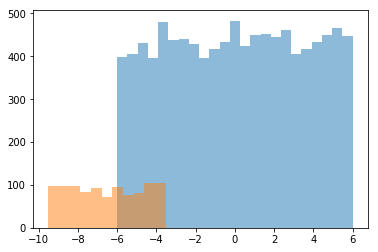

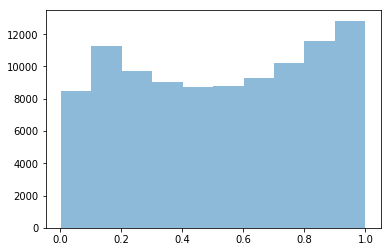

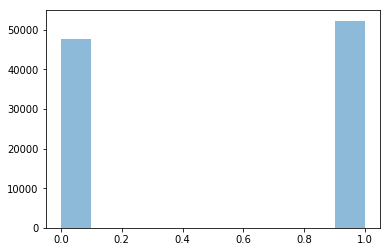

Instructions for updating:
Colocations handled automatically by placer.
<NN_utils.BigTable object at 0x7f2a07d8f6a0> <NN_utils.BigTable object at 0x7f2a07dd3320> Tensor("psi_select:0", shape=(?, 1), dtype=int32) Tensor("q_select:0", shape=(?, 1), dtype=int32)
psi_sel shape (?, 1)
kk (1000, 10)
selector shape (?, 1)
flat selector shape (?,)
call kk (1000, 10)
'rows' shape, (?, 10)
kk (100, 10)
selector shape (?, 1)
flat selector shape (?,)
call kk (100, 10)
'rows' shape, (?, 10)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
psi_select (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
q_select (InputLayer)           (None, 1)            0                                            
______________________

100000/100000 [==============================] - 0s 2us/step - loss: 0.5924 - acc: 0.6949
Epoch 48/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5908 - acc: 0.6951
Epoch 49/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5894 - acc: 0.6951
Epoch 50/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5881 - acc: 0.6955
Epoch 51/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5869 - acc: 0.6956
Epoch 52/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5857 - acc: 0.6960
Epoch 53/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5847 - acc: 0.6960
Epoch 54/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5837 - acc: 0.6958
Epoch 55/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5828 - acc: 0.6958
Epoch 56/100000
100000/100000 [==============================]

100000/100000 [==============================] - 0s 2us/step - loss: 0.5705 - acc: 0.6973
Epoch 125/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5705 - acc: 0.6970
Epoch 126/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5705 - acc: 0.6973
Epoch 127/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5704 - acc: 0.6974
Epoch 128/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5704 - acc: 0.6974
Epoch 129/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5703 - acc: 0.6972
Epoch 130/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5703 - acc: 0.6976
Epoch 131/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5702 - acc: 0.6974
Epoch 132/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5702 - acc: 0.6973
Epoch 133/100000
100000/100000 [======================

100000/100000 [==============================] - 0s 2us/step - loss: 0.5533 - acc: 0.7123
Epoch 201/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5528 - acc: 0.7129
Epoch 202/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5522 - acc: 0.7132
Epoch 203/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5516 - acc: 0.7137
Epoch 204/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5510 - acc: 0.7145
Epoch 205/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5504 - acc: 0.7148
Epoch 206/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5498 - acc: 0.7153
Epoch 207/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5492 - acc: 0.7160
Epoch 208/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5486 - acc: 0.7164
Epoch 209/100000
100000/100000 [======================

100000/100000 [==============================] - 0s 2us/step - loss: 0.5085 - acc: 0.7481
Epoch 277/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5080 - acc: 0.7485
Epoch 278/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5076 - acc: 0.7488
Epoch 279/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5071 - acc: 0.7492
Epoch 280/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5067 - acc: 0.7496
Epoch 281/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5062 - acc: 0.7499
Epoch 282/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5058 - acc: 0.7500
Epoch 283/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5054 - acc: 0.7503
Epoch 284/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.5049 - acc: 0.7504
Epoch 285/100000
100000/100000 [======================

100000/100000 [==============================] - 0s 2us/step - loss: 0.4845 - acc: 0.7617
Epoch 353/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4843 - acc: 0.7618
Epoch 354/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4841 - acc: 0.7620
Epoch 355/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4839 - acc: 0.7622
Epoch 356/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4837 - acc: 0.7622
Epoch 357/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4835 - acc: 0.7622
Epoch 358/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4833 - acc: 0.7623
Epoch 359/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4831 - acc: 0.7623
Epoch 360/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4829 - acc: 0.7625
Epoch 361/100000
100000/100000 [======================

100000/100000 [==============================] - 0s 2us/step - loss: 0.4734 - acc: 0.7675
Epoch 429/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4734 - acc: 0.7675
Epoch 430/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4732 - acc: 0.7675
Epoch 431/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4731 - acc: 0.7675
Epoch 432/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4731 - acc: 0.7676
Epoch 433/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4730 - acc: 0.7677
Epoch 434/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4729 - acc: 0.7677
Epoch 435/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4728 - acc: 0.7678
Epoch 436/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4727 - acc: 0.7680
Epoch 437/100000
100000/100000 [======================

100000/100000 [==============================] - 0s 2us/step - loss: 0.4677 - acc: 0.7713
Epoch 505/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4676 - acc: 0.7715
Epoch 506/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4676 - acc: 0.7713
Epoch 507/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4675 - acc: 0.7715
Epoch 508/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4674 - acc: 0.7715
Epoch 509/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4674 - acc: 0.7717
Epoch 510/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4673 - acc: 0.7716
Epoch 511/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4673 - acc: 0.7717
Epoch 512/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4672 - acc: 0.7716
Epoch 513/100000
100000/100000 [======================

100000/100000 [==============================] - 0s 2us/step - loss: 0.4642 - acc: 0.7730
Epoch 581/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4642 - acc: 0.7729
Epoch 582/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4642 - acc: 0.7730
Epoch 583/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4641 - acc: 0.7728
Epoch 584/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4641 - acc: 0.7730
Epoch 585/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4641 - acc: 0.7729
Epoch 586/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4640 - acc: 0.7728
Epoch 587/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4640 - acc: 0.7730
Epoch 588/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4640 - acc: 0.7730
Epoch 589/100000
100000/100000 [======================

100000/100000 [==============================] - 0s 2us/step - loss: 0.4620 - acc: 0.7739
Epoch 657/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4620 - acc: 0.7738
Epoch 658/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4619 - acc: 0.7739
Epoch 659/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4619 - acc: 0.7740
Epoch 660/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4619 - acc: 0.7740
Epoch 661/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4619 - acc: 0.7739
Epoch 662/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4618 - acc: 0.7742
Epoch 663/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4618 - acc: 0.7740
Epoch 664/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4618 - acc: 0.7740
Epoch 665/100000
100000/100000 [======================

100000/100000 [==============================] - 0s 2us/step - loss: 0.4604 - acc: 0.7749
Epoch 733/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4603 - acc: 0.7750
Epoch 734/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4603 - acc: 0.7751
Epoch 735/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4603 - acc: 0.7750
Epoch 736/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4603 - acc: 0.7750
Epoch 737/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4603 - acc: 0.7749
Epoch 738/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4603 - acc: 0.7750
Epoch 739/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4602 - acc: 0.7752
Epoch 740/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4602 - acc: 0.7751
Epoch 741/100000
100000/100000 [======================

100000/100000 [==============================] - 0s 2us/step - loss: 0.4591 - acc: 0.7760
Epoch 809/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4591 - acc: 0.7760
Epoch 810/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4591 - acc: 0.7761
Epoch 811/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4591 - acc: 0.7761
Epoch 812/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4591 - acc: 0.7761
Epoch 813/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4590 - acc: 0.7760
Epoch 814/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4590 - acc: 0.7761
Epoch 815/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4590 - acc: 0.7760
Epoch 816/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4590 - acc: 0.7760
Epoch 817/100000
100000/100000 [======================

100000/100000 [==============================] - 0s 2us/step - loss: 0.4581 - acc: 0.7767
Epoch 885/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4581 - acc: 0.7767
Epoch 886/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4581 - acc: 0.7768
Epoch 887/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4581 - acc: 0.7768
Epoch 888/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4581 - acc: 0.7769
Epoch 889/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4581 - acc: 0.7768
Epoch 890/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4580 - acc: 0.7770
Epoch 891/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4580 - acc: 0.7768
Epoch 892/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4580 - acc: 0.7769
Epoch 893/100000
100000/100000 [======================

100000/100000 [==============================] - 0s 2us/step - loss: 0.4573 - acc: 0.7774
Epoch 961/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4573 - acc: 0.7774
Epoch 962/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4573 - acc: 0.7776
Epoch 963/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4572 - acc: 0.7775
Epoch 964/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4572 - acc: 0.7776
Epoch 965/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4572 - acc: 0.7775
Epoch 966/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4572 - acc: 0.7773
Epoch 967/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4572 - acc: 0.7774
Epoch 968/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4572 - acc: 0.7775
Epoch 969/100000
100000/100000 [======================

100000/100000 [==============================] - 0s 2us/step - loss: 0.4565 - acc: 0.7779
Epoch 1037/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4565 - acc: 0.7779
Epoch 1038/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4565 - acc: 0.7781
Epoch 1039/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4565 - acc: 0.7780
Epoch 1040/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4565 - acc: 0.7780
Epoch 1041/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4565 - acc: 0.7779
Epoch 1042/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4565 - acc: 0.7780
Epoch 1043/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4565 - acc: 0.7780
Epoch 1044/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4565 - acc: 0.7780
Epoch 1045/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4559 - acc: 0.7786
Epoch 1113/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4559 - acc: 0.7786
Epoch 1114/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4558 - acc: 0.7785
Epoch 1115/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4558 - acc: 0.7786
Epoch 1116/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4558 - acc: 0.7786
Epoch 1117/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4558 - acc: 0.7786
Epoch 1118/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4558 - acc: 0.7786
Epoch 1119/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4558 - acc: 0.7788
Epoch 1120/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4558 - acc: 0.7784
Epoch 1121/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4553 - acc: 0.7789
Epoch 1189/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4553 - acc: 0.7790
Epoch 1190/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4553 - acc: 0.7788
Epoch 1191/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4552 - acc: 0.7788
Epoch 1192/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4552 - acc: 0.7789
Epoch 1193/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4552 - acc: 0.7789
Epoch 1194/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4552 - acc: 0.7789
Epoch 1195/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4552 - acc: 0.7790
Epoch 1196/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4552 - acc: 0.7788
Epoch 1197/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4547 - acc: 0.7792
Epoch 1265/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4547 - acc: 0.7794
Epoch 1266/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4547 - acc: 0.7793
Epoch 1267/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4547 - acc: 0.7793
Epoch 1268/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4547 - acc: 0.7795
Epoch 1269/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4547 - acc: 0.7794
Epoch 1270/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4547 - acc: 0.7793
Epoch 1271/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4547 - acc: 0.7795
Epoch 1272/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4547 - acc: 0.7794
Epoch 1273/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4542 - acc: 0.7798
Epoch 1341/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4542 - acc: 0.7799
Epoch 1342/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4542 - acc: 0.7800
Epoch 1343/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4542 - acc: 0.7798
Epoch 1344/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4542 - acc: 0.7800
Epoch 1345/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4542 - acc: 0.7799
Epoch 1346/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4542 - acc: 0.7799
Epoch 1347/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4542 - acc: 0.7801
Epoch 1348/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4542 - acc: 0.7800
Epoch 1349/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4538 - acc: 0.7802
Epoch 1417/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4538 - acc: 0.7801
Epoch 1418/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4538 - acc: 0.7801
Epoch 1419/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4538 - acc: 0.7801
Epoch 1420/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4537 - acc: 0.7801
Epoch 1421/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4537 - acc: 0.7800
Epoch 1422/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4537 - acc: 0.7801
Epoch 1423/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4537 - acc: 0.7802
Epoch 1424/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4537 - acc: 0.7802
Epoch 1425/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4533 - acc: 0.7808
Epoch 1493/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4533 - acc: 0.7804
Epoch 1494/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4533 - acc: 0.7806
Epoch 1495/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4533 - acc: 0.7806
Epoch 1496/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4533 - acc: 0.7807
Epoch 1497/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4533 - acc: 0.7807
Epoch 1498/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4533 - acc: 0.7809
Epoch 1499/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4533 - acc: 0.7806
Epoch 1500/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4533 - acc: 0.7808
Epoch 1501/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4529 - acc: 0.7814
Epoch 1569/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4529 - acc: 0.7813
Epoch 1570/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4529 - acc: 0.7815
Epoch 1571/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4529 - acc: 0.7813
Epoch 1572/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4529 - acc: 0.7813
Epoch 1573/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4529 - acc: 0.7813
Epoch 1574/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4529 - acc: 0.7816
Epoch 1575/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4529 - acc: 0.7814
Epoch 1576/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4529 - acc: 0.7814
Epoch 1577/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4525 - acc: 0.7816
Epoch 1645/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4525 - acc: 0.7816
Epoch 1646/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4525 - acc: 0.7816
Epoch 1647/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4525 - acc: 0.7816
Epoch 1648/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4525 - acc: 0.7816
Epoch 1649/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4525 - acc: 0.7816
Epoch 1650/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4525 - acc: 0.7815
Epoch 1651/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4525 - acc: 0.7817
Epoch 1652/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4525 - acc: 0.7818
Epoch 1653/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4521 - acc: 0.7818
Epoch 1721/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4522 - acc: 0.7818
Epoch 1722/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4521 - acc: 0.7820
Epoch 1723/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4521 - acc: 0.7820
Epoch 1724/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4521 - acc: 0.7818
Epoch 1725/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4521 - acc: 0.7819
Epoch 1726/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4521 - acc: 0.7818
Epoch 1727/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4521 - acc: 0.7819
Epoch 1728/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4521 - acc: 0.7818
Epoch 1729/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4518 - acc: 0.7818
Epoch 1797/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4518 - acc: 0.7821
Epoch 1798/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4518 - acc: 0.7820
Epoch 1799/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4518 - acc: 0.7819
Epoch 1800/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4518 - acc: 0.7819
Epoch 1801/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4518 - acc: 0.7821
Epoch 1802/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4518 - acc: 0.7819
Epoch 1803/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4518 - acc: 0.7821
Epoch 1804/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4518 - acc: 0.7819
Epoch 1805/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4515 - acc: 0.7825
Epoch 1873/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4515 - acc: 0.7826
Epoch 1874/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4515 - acc: 0.7825
Epoch 1875/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4515 - acc: 0.7826
Epoch 1876/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4515 - acc: 0.7826
Epoch 1877/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4514 - acc: 0.7826
Epoch 1878/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4514 - acc: 0.7826
Epoch 1879/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4514 - acc: 0.7825
Epoch 1880/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4514 - acc: 0.7827
Epoch 1881/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4511 - acc: 0.7830
Epoch 1949/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4511 - acc: 0.7831
Epoch 1950/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4511 - acc: 0.7830
Epoch 1951/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4511 - acc: 0.7829
Epoch 1952/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4511 - acc: 0.7830
Epoch 1953/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4511 - acc: 0.7829
Epoch 1954/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4511 - acc: 0.7828
Epoch 1955/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4511 - acc: 0.7828
Epoch 1956/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4511 - acc: 0.7829
Epoch 1957/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4508 - acc: 0.7831
Epoch 2025/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4508 - acc: 0.7831
Epoch 2026/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4508 - acc: 0.7830
Epoch 2027/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4508 - acc: 0.7830
Epoch 2028/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4508 - acc: 0.7830
Epoch 2029/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4508 - acc: 0.7830
Epoch 2030/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4508 - acc: 0.7830
Epoch 2031/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4508 - acc: 0.7831
Epoch 2032/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4507 - acc: 0.7830
Epoch 2033/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4504 - acc: 0.7834
Epoch 2101/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4504 - acc: 0.7834
Epoch 2102/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4504 - acc: 0.7832
Epoch 2103/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4504 - acc: 0.7834
Epoch 2104/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4504 - acc: 0.7835
Epoch 2105/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4504 - acc: 0.7835
Epoch 2106/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4504 - acc: 0.7834
Epoch 2107/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4504 - acc: 0.7835
Epoch 2108/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4504 - acc: 0.7835
Epoch 2109/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4501 - acc: 0.7839
Epoch 2177/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4501 - acc: 0.7837
Epoch 2178/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4501 - acc: 0.7838
Epoch 2179/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4501 - acc: 0.7838
Epoch 2180/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4501 - acc: 0.7837
Epoch 2181/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4501 - acc: 0.7837
Epoch 2182/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4501 - acc: 0.7836
Epoch 2183/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4501 - acc: 0.7837
Epoch 2184/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4501 - acc: 0.7838
Epoch 2185/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4498 - acc: 0.7838
Epoch 2253/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4498 - acc: 0.7838
Epoch 2254/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4498 - acc: 0.7837
Epoch 2255/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4498 - acc: 0.7837
Epoch 2256/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4498 - acc: 0.7837
Epoch 2257/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4498 - acc: 0.7839
Epoch 2258/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4498 - acc: 0.7838
Epoch 2259/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4498 - acc: 0.7837
Epoch 2260/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4497 - acc: 0.7837
Epoch 2261/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4495 - acc: 0.7840
Epoch 2329/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4495 - acc: 0.7838
Epoch 2330/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4495 - acc: 0.7836
Epoch 2331/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4495 - acc: 0.7837
Epoch 2332/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4495 - acc: 0.7837
Epoch 2333/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4495 - acc: 0.7838
Epoch 2334/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4495 - acc: 0.7838
Epoch 2335/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4495 - acc: 0.7838
Epoch 2336/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4494 - acc: 0.7838
Epoch 2337/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4492 - acc: 0.7842
Epoch 2405/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4492 - acc: 0.7840
Epoch 2406/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4492 - acc: 0.7842
Epoch 2407/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4492 - acc: 0.7844
Epoch 2408/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4492 - acc: 0.7842
Epoch 2409/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4492 - acc: 0.7843
Epoch 2410/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4492 - acc: 0.7843
Epoch 2411/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4492 - acc: 0.7842
Epoch 2412/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4492 - acc: 0.7842
Epoch 2413/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4490 - acc: 0.7838
Epoch 2481/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4489 - acc: 0.7839
Epoch 2482/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4489 - acc: 0.7839
Epoch 2483/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4489 - acc: 0.7840
Epoch 2484/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4489 - acc: 0.7841
Epoch 2485/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4489 - acc: 0.7840
Epoch 2486/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4489 - acc: 0.7839
Epoch 2487/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4489 - acc: 0.7840
Epoch 2488/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4489 - acc: 0.7840
Epoch 2489/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4487 - acc: 0.7841
Epoch 2557/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4487 - acc: 0.7841
Epoch 2558/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4487 - acc: 0.7840
Epoch 2559/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4487 - acc: 0.7841
Epoch 2560/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4487 - acc: 0.7841
Epoch 2561/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4487 - acc: 0.7841
Epoch 2562/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4487 - acc: 0.7842
Epoch 2563/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4487 - acc: 0.7841
Epoch 2564/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4487 - acc: 0.7841
Epoch 2565/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4485 - acc: 0.7844
Epoch 2633/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4485 - acc: 0.7843
Epoch 2634/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4485 - acc: 0.7844
Epoch 2635/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4485 - acc: 0.7843
Epoch 2636/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4485 - acc: 0.7843
Epoch 2637/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4485 - acc: 0.7843
Epoch 2638/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4485 - acc: 0.7844
Epoch 2639/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4485 - acc: 0.7843
Epoch 2640/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4485 - acc: 0.7842
Epoch 2641/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4483 - acc: 0.7846
Epoch 2709/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4483 - acc: 0.7847
Epoch 2710/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4483 - acc: 0.7847
Epoch 2711/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4483 - acc: 0.7846
Epoch 2712/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4483 - acc: 0.7847
Epoch 2713/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4483 - acc: 0.7848
Epoch 2714/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4482 - acc: 0.7846
Epoch 2715/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4482 - acc: 0.7846
Epoch 2716/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4482 - acc: 0.7848
Epoch 2717/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4480 - acc: 0.7851
Epoch 2785/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4480 - acc: 0.7851
Epoch 2786/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4480 - acc: 0.7848
Epoch 2787/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4480 - acc: 0.7850
Epoch 2788/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4480 - acc: 0.7849
Epoch 2789/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4480 - acc: 0.7851
Epoch 2790/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4480 - acc: 0.7850
Epoch 2791/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4480 - acc: 0.7851
Epoch 2792/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4480 - acc: 0.7850
Epoch 2793/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4478 - acc: 0.7851
Epoch 2861/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4478 - acc: 0.7852
Epoch 2862/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4478 - acc: 0.7850
Epoch 2863/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4478 - acc: 0.7851
Epoch 2864/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4478 - acc: 0.7851
Epoch 2865/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4478 - acc: 0.7851
Epoch 2866/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4478 - acc: 0.7852
Epoch 2867/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4478 - acc: 0.7852
Epoch 2868/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4478 - acc: 0.7852
Epoch 2869/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4477 - acc: 0.7854
Epoch 2937/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4476 - acc: 0.7856
Epoch 2938/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4477 - acc: 0.7854
Epoch 2939/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4477 - acc: 0.7853
Epoch 2940/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4476 - acc: 0.7854
Epoch 2941/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4476 - acc: 0.7855
Epoch 2942/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4476 - acc: 0.7853
Epoch 2943/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4476 - acc: 0.7854
Epoch 2944/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4476 - acc: 0.7856
Epoch 2945/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4475 - acc: 0.7855
Epoch 3013/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4475 - acc: 0.7856
Epoch 3014/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4475 - acc: 0.7856
Epoch 3015/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4475 - acc: 0.7855
Epoch 3016/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4475 - acc: 0.7855
Epoch 3017/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4475 - acc: 0.7857
Epoch 3018/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4475 - acc: 0.7856
Epoch 3019/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4475 - acc: 0.7855
Epoch 3020/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4475 - acc: 0.7854
Epoch 3021/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4473 - acc: 0.7854
Epoch 3089/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4473 - acc: 0.7856
Epoch 3090/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4473 - acc: 0.7854
Epoch 3091/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4473 - acc: 0.7856
Epoch 3092/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4473 - acc: 0.7856
Epoch 3093/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4473 - acc: 0.7856
Epoch 3094/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4473 - acc: 0.7857
Epoch 3095/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4473 - acc: 0.7856
Epoch 3096/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4473 - acc: 0.7856
Epoch 3097/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4471 - acc: 0.7860
Epoch 3165/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4471 - acc: 0.7860
Epoch 3166/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4471 - acc: 0.7861
Epoch 3167/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4471 - acc: 0.7860
Epoch 3168/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4471 - acc: 0.7860
Epoch 3169/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4471 - acc: 0.7860
Epoch 3170/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4471 - acc: 0.7861
Epoch 3171/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4471 - acc: 0.7861
Epoch 3172/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4471 - acc: 0.7861
Epoch 3173/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4470 - acc: 0.7862
Epoch 3241/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4470 - acc: 0.7862
Epoch 3242/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4470 - acc: 0.7861
Epoch 3243/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4470 - acc: 0.7861
Epoch 3244/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4470 - acc: 0.7861
Epoch 3245/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4470 - acc: 0.7862
Epoch 3246/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4470 - acc: 0.7862
Epoch 3247/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4470 - acc: 0.7861
Epoch 3248/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4470 - acc: 0.7864
Epoch 3249/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4468 - acc: 0.7863
Epoch 3317/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4468 - acc: 0.7863
Epoch 3318/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4468 - acc: 0.7863
Epoch 3319/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4468 - acc: 0.7862
Epoch 3320/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4468 - acc: 0.7863
Epoch 3321/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4468 - acc: 0.7864
Epoch 3322/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4468 - acc: 0.7862
Epoch 3323/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4468 - acc: 0.7862
Epoch 3324/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4468 - acc: 0.7863
Epoch 3325/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4467 - acc: 0.7864
Epoch 3393/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4467 - acc: 0.7863
Epoch 3394/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4467 - acc: 0.7863
Epoch 3395/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4467 - acc: 0.7862
Epoch 3396/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4467 - acc: 0.7864
Epoch 3397/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4467 - acc: 0.7864
Epoch 3398/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4467 - acc: 0.7865
Epoch 3399/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4467 - acc: 0.7864
Epoch 3400/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4467 - acc: 0.7864
Epoch 3401/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4465 - acc: 0.7865
Epoch 3469/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4465 - acc: 0.7865
Epoch 3470/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4465 - acc: 0.7864
Epoch 3471/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4465 - acc: 0.7864
Epoch 3472/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4465 - acc: 0.7866
Epoch 3473/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4465 - acc: 0.7865
Epoch 3474/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4465 - acc: 0.7866
Epoch 3475/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4465 - acc: 0.7864
Epoch 3476/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4465 - acc: 0.7865
Epoch 3477/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4464 - acc: 0.7865
Epoch 3545/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4464 - acc: 0.7864
Epoch 3546/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4464 - acc: 0.7865
Epoch 3547/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4464 - acc: 0.7864
Epoch 3548/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4464 - acc: 0.7862
Epoch 3549/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4464 - acc: 0.7864
Epoch 3550/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4464 - acc: 0.7864
Epoch 3551/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4464 - acc: 0.7865
Epoch 3552/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4464 - acc: 0.7863
Epoch 3553/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4463 - acc: 0.7863
Epoch 3621/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4463 - acc: 0.7864
Epoch 3622/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4463 - acc: 0.7864
Epoch 3623/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4463 - acc: 0.7864
Epoch 3624/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4463 - acc: 0.7865
Epoch 3625/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4463 - acc: 0.7865
Epoch 3626/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4463 - acc: 0.7865
Epoch 3627/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4463 - acc: 0.7865
Epoch 3628/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4463 - acc: 0.7865
Epoch 3629/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4461 - acc: 0.7866
Epoch 3697/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4461 - acc: 0.7864
Epoch 3698/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4461 - acc: 0.7865
Epoch 3699/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4461 - acc: 0.7866
Epoch 3700/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4461 - acc: 0.7865
Epoch 3701/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4461 - acc: 0.7864
Epoch 3702/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4461 - acc: 0.7865
Epoch 3703/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4461 - acc: 0.7866
Epoch 3704/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4461 - acc: 0.7865
Epoch 3705/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4460 - acc: 0.7865
Epoch 3773/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4460 - acc: 0.7864
Epoch 3774/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4460 - acc: 0.7866
Epoch 3775/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4460 - acc: 0.7865
Epoch 3776/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4460 - acc: 0.7866
Epoch 3777/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4460 - acc: 0.7865
Epoch 3778/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4460 - acc: 0.7865
Epoch 3779/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4460 - acc: 0.7866
Epoch 3780/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4460 - acc: 0.7865
Epoch 3781/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4459 - acc: 0.7866
Epoch 3849/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4459 - acc: 0.7867
Epoch 3850/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4459 - acc: 0.7867
Epoch 3851/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4459 - acc: 0.7867
Epoch 3852/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4459 - acc: 0.7867
Epoch 3853/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4459 - acc: 0.7867
Epoch 3854/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4459 - acc: 0.7867
Epoch 3855/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4459 - acc: 0.7866
Epoch 3856/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4459 - acc: 0.7866
Epoch 3857/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 3us/step - loss: 0.4458 - acc: 0.7869
Epoch 3925/100000
100000/100000 [==============================] - 0s 3us/step - loss: 0.4458 - acc: 0.7869
Epoch 3926/100000
100000/100000 [==============================] - 0s 3us/step - loss: 0.4458 - acc: 0.7869
Epoch 3927/100000
100000/100000 [==============================] - 0s 3us/step - loss: 0.4458 - acc: 0.7869
Epoch 3928/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4458 - acc: 0.7869
Epoch 3929/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4458 - acc: 0.7870
Epoch 3930/100000
100000/100000 [==============================] - 0s 4us/step - loss: 0.4458 - acc: 0.7869
Epoch 3931/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4458 - acc: 0.7869
Epoch 3932/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4458 - acc: 0.7869
Epoch 3933/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4457 - acc: 0.7869
Epoch 4001/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4457 - acc: 0.7870
Epoch 4002/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4457 - acc: 0.7870
Epoch 4003/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4457 - acc: 0.7871
Epoch 4004/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4457 - acc: 0.7871
Epoch 4005/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4457 - acc: 0.7870
Epoch 4006/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4457 - acc: 0.7871
Epoch 4007/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4457 - acc: 0.7871
Epoch 4008/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4457 - acc: 0.7871
Epoch 4009/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4456 - acc: 0.7871
Epoch 4077/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4456 - acc: 0.7870
Epoch 4078/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4456 - acc: 0.7870
Epoch 4079/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4456 - acc: 0.7870
Epoch 4080/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4456 - acc: 0.7871
Epoch 4081/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4456 - acc: 0.7870
Epoch 4082/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4456 - acc: 0.7870
Epoch 4083/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4456 - acc: 0.7870
Epoch 4084/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4456 - acc: 0.7870
Epoch 4085/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 3us/step - loss: 0.4455 - acc: 0.7870
Epoch 4153/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4455 - acc: 0.7870
Epoch 4154/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4455 - acc: 0.7871
Epoch 4155/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4455 - acc: 0.7871
Epoch 4156/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4455 - acc: 0.7871
Epoch 4157/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4455 - acc: 0.7871
Epoch 4158/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4455 - acc: 0.7870
Epoch 4159/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4455 - acc: 0.7871
Epoch 4160/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4455 - acc: 0.7870
Epoch 4161/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4454 - acc: 0.7871
Epoch 4229/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4454 - acc: 0.7873
Epoch 4230/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4454 - acc: 0.7871
Epoch 4231/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4454 - acc: 0.7872
Epoch 4232/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4454 - acc: 0.7873
Epoch 4233/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4454 - acc: 0.7873
Epoch 4234/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4454 - acc: 0.7873
Epoch 4235/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4454 - acc: 0.7871
Epoch 4236/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4454 - acc: 0.7871
Epoch 4237/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4453 - acc: 0.7870
Epoch 4305/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4453 - acc: 0.7870
Epoch 4306/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4453 - acc: 0.7872
Epoch 4307/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4453 - acc: 0.7870
Epoch 4308/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4453 - acc: 0.7871
Epoch 4309/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4453 - acc: 0.7870
Epoch 4310/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4453 - acc: 0.7872
Epoch 4311/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4453 - acc: 0.7871
Epoch 4312/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4453 - acc: 0.7870
Epoch 4313/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4453 - acc: 0.7870
Epoch 4381/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4453 - acc: 0.7871
Epoch 4382/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4453 - acc: 0.7870
Epoch 4383/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4453 - acc: 0.7870
Epoch 4384/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4453 - acc: 0.7869
Epoch 4385/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4453 - acc: 0.7870
Epoch 4386/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4453 - acc: 0.7870
Epoch 4387/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4453 - acc: 0.7870
Epoch 4388/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4453 - acc: 0.7869
Epoch 4389/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4452 - acc: 0.7870
Epoch 4457/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4452 - acc: 0.7871
Epoch 4458/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4452 - acc: 0.7870
Epoch 4459/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4452 - acc: 0.7871
Epoch 4460/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4452 - acc: 0.7870
Epoch 4461/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4452 - acc: 0.7870
Epoch 4462/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4452 - acc: 0.7871
Epoch 4463/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4452 - acc: 0.7870
Epoch 4464/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4452 - acc: 0.7870
Epoch 4465/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4451 - acc: 0.7870
Epoch 4533/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4451 - acc: 0.7871
Epoch 4534/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4451 - acc: 0.7870
Epoch 4535/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4451 - acc: 0.7869
Epoch 4536/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4451 - acc: 0.7870
Epoch 4537/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4451 - acc: 0.7870
Epoch 4538/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4451 - acc: 0.7871
Epoch 4539/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4451 - acc: 0.7870
Epoch 4540/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4451 - acc: 0.7870
Epoch 4541/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4451 - acc: 0.7869
Epoch 4609/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4451 - acc: 0.7869
Epoch 4610/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4451 - acc: 0.7869
Epoch 4611/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4451 - acc: 0.7870
Epoch 4612/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4451 - acc: 0.7870
Epoch 4613/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4451 - acc: 0.7870
Epoch 4614/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4451 - acc: 0.7870
Epoch 4615/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4451 - acc: 0.7870
Epoch 4616/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4451 - acc: 0.7871
Epoch 4617/100000
100000/100000 [=============

100000/100000 [==============================] - 0s 2us/step - loss: 0.4450 - acc: 0.7870
Epoch 4685/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4450 - acc: 0.7871
Epoch 4686/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4450 - acc: 0.7871
Epoch 4687/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4450 - acc: 0.7870
Epoch 4688/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4450 - acc: 0.7870
Epoch 4689/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4450 - acc: 0.7870
Epoch 4690/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4450 - acc: 0.7868
Epoch 4691/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4450 - acc: 0.7870
Epoch 4692/100000
100000/100000 [==============================] - 0s 2us/step - loss: 0.4450 - acc: 0.7871
Epoch 4693/100000
100000/100000 [=============

In [11]:
import copy
# numpy.random.seed(666)
# n_students, n_questions, a0, a1, offset, test_w = (1000, 100, 0.8110750422323121, 1.1967074599870124, 0.53204746933021974, 2.6389781733222257)
n_students, n_questions = 1000,100
n_factors, min_active, max_active = (10,10,10)
# n_factors, min_active, max_active = (2,2,2)
# n_factors, min_active, max_active = (1,1,1)
# n_students, n_questions, a0, a1, offset, test_w = (5000, 100, 0.6516427938897171, 1.5588438755755065, 0.53204746933021974, 0.7168318678096066)

qws_list = []
sws_list = []
tr_list = []
questions=None
stu_list=[]
n_runs = 1
tw=None
qn_av = None
qn_std = None

a0s = numpy.linspace(-2,2,n_runs)

for a in range(n_runs):
#     a1,a0,av_c,offset,test_w = generate_params(min_active, max_active)
    _,_, a0, a1, offset, test_w =(None, None, 0.8110750422323121, 2, 0.53, 1) #1.1967074599870124, 0.53204746933021974, 2.6389781733222257)

    print(a0)
    test_w = 4
    a0 = 0.85

    test_w = 5
    a0 = 1

    test_w = 10
    a0 = 2.8
    
    test_w = 6
    a0 = 4
    
    if tw is None:
        tw=test_w
    _, _, students2, qz_temp  = gen_run(n_factors, a0, a1, min_active, max_active, test_w = tw)
    stu_list.append(students2)
        
    if questions is None:
        questions = qz_temp
        qn_av = numpy.mean(questions, axis=0)
        qn_std = numpy.std(questions, axis=0)
        plot_items([], questions, None)

    print("~ ~ ~ ~~ ATTEMPT",a, a0)
    bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

    plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
    plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
    plt.show()
        
#     (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2), obs2, probs2 = tvt_split(students2, questions, split_mode=1)
#     tr_list.append(((sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2)))

    sz=[]
    qz=[]
    pfz=[]
    probs=numpy.zeros((len(students2), len(questions)))
    for vi in range(len(students2)):
        for mi in range(len(questions)):
            for _ in range(1):
    #                 zmask = (qws[mi]==-10).astype(int)
                deltas = students2[vi]-questions[mi]
                prs = logistic(deltas,1,0)
                pr = numpy.prod(prs)
    #                 prs = numpy.maximum(zmask,prs)
                sz.append(vi)
                qz.append(mi)
                ob = (random.random() < pr)
                probs[vi,mi] = pr
                pfz.append(ob)
    
    plt.hist(probs.flatten(), alpha=0.5)
    plt.show()
    
    plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
    plt.show()

    vqz2,vsz2,vpfz2 = [],[],[]
    
# for runix in range(n_runs):
#     (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2) = tr_list[runix]
    s_table2, qn_table2, _, m2, h2 = generate_and_train(qz,sz,pfz, vqz2,vsz2,vpfz2, w=n_factors, qn_av=qn_av, qn_std=qn_std)
    qws2= copy.copy(qn_table2.get_weights()[0])
    sws2= copy.copy(s_table2.get_weights()[0])
#     qg = q_gates.get_weights()[0]
#     qg_list.append(qg)
#     if qn_av is None:
#         qn_av = numpy.mean(qws2)

    sws_list.append(sws2)
    qws_list.append(qws2)

pred list shape (0,)
real items shape (100, 10)


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide


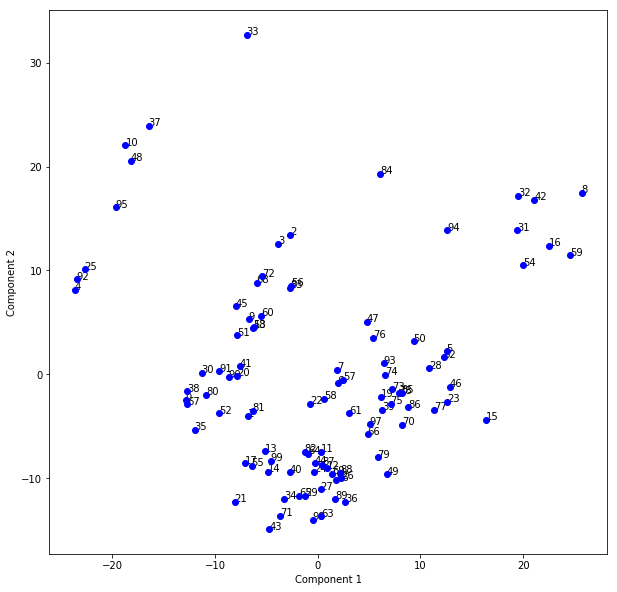

len Cs 0
Mean rand score = nan nan


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
for qns in qws_list:
    plot_items([], qns, None)

There are 1 els in sws_list and 1 els in qws_list


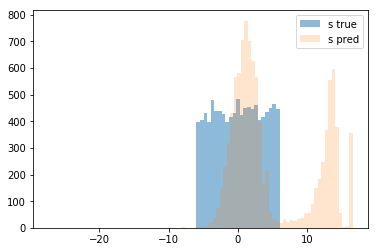

85
len qws_list 1
med -4.51318


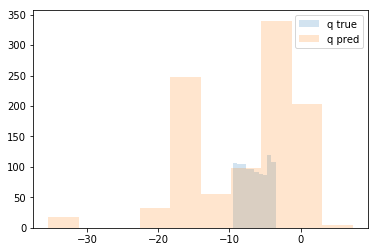

In [13]:
# sws2= s_table2.get_weights()[0]
# qws2= qn_table2.get_weights()[0]

# offset = numpy.mean(students2) - numpy.mean(sws2) 
# qws2 = qws2# + offset
# sws2 = sws2# + offset

bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

for ss in stu_list:
    plt.hist(ss.flatten(), alpha=0.5, bins=bin_spread(ss), label="s true")
# plt.legend()
# plt.show()

print("There are {} els in sws_list and {} els in qws_list".format(len(sws_list), len(qws_list)))

sw_av_list = []
for sw in sws_list:
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
    plt.hist(sw.flatten(), alpha=0.2, bins=bin_spread(sw), label="s pred")
    sw_av_list.append(numpy.median(sw.flatten()))
plt.legend()
plt.show()


plt.hist(questions.flatten(), alpha=0.2, label="q true")#, bins=bin_spread(questions))
print(bin_spread(qws2))
# plt.show()

# qws_list_2 = []
real_max_q = numpy.max(questions.flatten())
print("len qws_list", len(qws_list))

for qw in qws_list:#, sw_av_list):
    qw = copy.copy(qw)
    print("med",numpy.median(qw))
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
#     qg2 = (qg>0.5).astype(int)
#     masqd = qw*qg2
#     qws_list_2.append(masqd)
#     print(qw)
#     print(qg)
#     plt.hist(qw[list(set(qz))].flatten(), alpha=0.4, bins=bin_spread(qw))

#     max_q = numpy.max(qw)
#     os = real_max_q - max_q
#     qw += os

#     thresh = 0
#     qw[qw < thresh] = 0
    plt.hist(qw.flatten(), alpha=0.2, label="q pred")#, bins=bin_spread(qw))
plt.legend()
plt.show()


# qws_list = qws_list2

In [303]:
# s_offset = ((numpy.max(students, axis=0)-numpy.min(students, axis=0))/2 - (numpy.max(sws2, axis=0)- numpy.min(sws2, axis=0))/2)
# s_offset = (numpy.median(students, axis=0) - numpy.median(sws2, axis=0))
# s_offset = numpy.median(questions, axis=0) - numpy.median(qws2, axis=0)
# np_sws_list = numpy.array(sws_list)
# print(np_sws_list)

# # for sw in sws_list:
# s_offset = numpy.median(numpy.median(sws_list, axis=1), axis=0)
# s_sd = numpy.median(numpy.std(sws_list, axis=1), axis=0)
# print(s_offset, s_sd)

# s_offset = s_offset- 2.7*s_sd
# print(s_offset)
# q_offset = numpy.median(qw, axis=1)
# q_offset = numpy.median(q_offset, axis=0)
# # s_offset = numpy.median(s_offset, axis=0)
# # print(s_offset)
# print("\n",q_offset)

# for sw in sws_list:
# s_offset = numpy.min(sws_list, axis=1)
# print(s_offset)

# s_offset = numpy.median(numpy.min(sws_list, axis=1), axis=0)
# s_sd = numpy.median(numpy.std(sws_list, axis=1), axis=0)
# print(s_offset, s_sd)

qw_min_list = []
for qws in qws_list:
    qws[qws < -1] = numpy.nan
#     means = np.nanmean(data[:, 1:], axis=1)
    qwm=numpy.nanmedian(qws, axis=0)
    qw_min_list.append(qwm)
    qws[numpy.isnan(qws)] = 0
print(qw_min_list)
s_offset = qw_min_list

[array([ 0.80471098], dtype=float32), array([ 1.05939078], dtype=float32), array([ 1.11441767], dtype=float32)]


In [579]:
import copy
def stats_about_stuff(real_items):
    cp = copy.copy(real_items)
    cp[cp==0]=numpy.nan
    meds = numpy.nanmedian(real_items, axis=0)
    meansnan = numpy.nanmean(cp, axis=0)
    medsnan = numpy.nanmedian(cp, axis=0)
    q_mx = (real_items>=(meds-5))#.astype(int)
#     print(cp)
    print(meds)
    print(medsnan)
    print(meansnan)
#     print(q_mx)
    for ix,it in enumerate(real_items):
        qrow = (it>0).astype(int)
        print(ix, qrow, sum(qrow), numpy.median(it[it>0]))#, numpy.linalg.norm(it[it>0]))

stats_about_stuff(questions)

[-2.77 -2.65 -2.42 -2.49 -2.66 -2.35 -2.65 -2.59 -2.6  -2.56]
[-2.77 -2.65 -2.42 -2.49 -2.66 -2.35 -2.65 -2.59 -2.6  -2.56]
[-2.66 -2.63 -2.53 -2.57 -2.65 -2.53 -2.6  -2.66 -2.58 -2.62]
0 [0 0 0 0 0 0 0 0 0 0] 0 nan
1 [0 0 0 0 0 0 0 0 0 0] 0 nan
2 [0 0 0 0 0 0 0 0 0 0] 0 nan
3 [0 0 0 0 0 0 0 0 0 0] 0 nan
4 [0 0 0 0 0 0 0 0 0 0] 0 nan
5 [0 0 0 0 0 0 0 0 0 0] 0 nan
6 [0 0 0 0 0 0 0 0 0 0] 0 nan
7 [0 0 0 0 0 0 0 0 0 0] 0 nan
8 [0 0 0 0 0 0 0 0 0 0] 0 nan
9 [0 0 0 0 0 0 0 0 0 0] 0 nan
10 [0 0 0 0 0 0 0 0 0 0] 0 nan
11 [0 0 0 0 0 0 0 0 0 0] 0 nan
12 [0 0 0 0 0 0 0 0 0 0] 0 nan
13 [0 0 0 0 0 0 0 0 0 0] 0 nan
14 [0 0 0 0 0 0 0 0 0 0] 0 nan
15 [0 0 0 0 0 0 0 0 0 0] 0 nan
16 [0 0 0 0 0 0 0 0 0 0] 0 nan
17 [0 0 0 0 0 0 0 0 0 0] 0 nan
18 [0 0 0 0 0 0 0 0 0 0] 0 nan
19 [0 0 0 0 0 0 0 0 0 0] 0 nan
20 [0 0 0 0 0 0 0 0 0 0] 0 nan
21 [0 0 0 0 0 0 0 0 0 0] 0 nan
22 [0 0 0 0 0 0 0 0 0 0] 0 nan
23 [0 0 0 0 0 0 0 0 0 0] 0 nan
24 [0 0 0 0 0 0 0 0 0 0] 0 nan
25 [0 0 0 0 0 0 0 0 0 0] 0 nan
26 [0 0 0 0 0 0 0 

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
numpy.set_printoptions(precision=2, suppress=True, threshold=100)
def create_adj_mx(nodes):
    L = numpy.zeros((len(nodes), len(nodes)))
    for i in range(len(nodes)):
        sum_dist = 0
        for j in range(len(nodes)):
            dist = numpy.linalg.norm(nodes[j]-nodes[i], ord=2)
            L[i,j] = dist
    return L

def create_laplacian(nodes):
    amx = create_adj_mx(nodes)
    L = -amx #negate the adj mx
    for ix,row in enumerate(L):
        deg = -numpy.sum(row)
        L[ix,ix] = deg
    return L

def graph_adj_mx(L, n=3, fn="adj_mx"):
    from graphviz import Graph
    gg = Graph(strict=True, filename=fn)
    if L[0,1]<0:
        L = -L
    for ix in range(len(L)):
        row = L[ix,:]
        js = numpy.argsort(row)[1:n+1]
        for j in js:
            v = row[j]
            tup = str(ix),str(j),str(round(v,2))
#             print("cadd edge", tup)
            sta,end,lab = tup
            gg.edge(sta,end, label=str(lab))
    gg.view()


amx = create_adj_mx(questions)
print(amx)
graph_adj_mx(amx)

    
# numpy.set_printoptions(precision=2, suppress=True, threshold=100000)
# print(L0.argsort(axis=1))
m=3
L1 = create_laplacian(questions)
print(L1)
graph_adj_mx(L1, fn="original", n=m)

for j,q in enumerate(qws_list):
    L1 = create_laplacian(q)
    graph_adj_mx(L1, fn="facsimile_{}".format(j), n=m)

# lams = numpy.linalg.eigvalsh(L0)
# sum_eig = sum(lams)
# sum_upto = 0
# ct=0
# for lam in lams:
#     sum_upto += lam
#     if sum_upto > 0.9*sum_eig:
#         print("broke loop at \lambda_{}".format(ct))
#         break
#     ct+=1

In [88]:
def print_comparison(pred_list, real_items):
    for items in pred_list:
        for item, real_item in zip(items, real_items):
            print(numpy.sort(real_item))
            print(numpy.sort(item))
            print()

numpy.set_printoptions(precision=2)
print_comparison(qws_list, questions)

[-18.85 -18.43 -15.37  -8.58  -8.56  -7.52  -6.74  -3.92  -3.23   0.13]
[-14.14 -13.68 -13.47 -13.14 -13.12 -13.02 -11.04  -5.87  -1.26   0.27]

[-19.12 -18.57 -15.2  -15.05 -11.53 -10.38 -10.05  -8.45  -6.51  -0.64]
[-14.37 -14.28 -13.69 -13.39 -12.92 -12.92 -12.58 -12.25  -1.73  -1.21]

[-18.04 -16.56 -15.78 -15.62 -12.5   -7.78  -6.22  -4.36  -2.97   0.65]
[-13.58 -12.82 -12.33 -12.16 -11.23  -7.05  -5.82  -1.82  -0.26   0.08]

[-18.4  -16.76 -16.37 -11.37 -10.52  -8.84  -4.86  -3.21  -3.16  -0.35]
[-14.03 -13.76 -13.66 -13.58 -13.54 -13.31 -12.4   -3.29  -1.25  -0.79]

[-18.85 -18.2  -18.07 -14.35 -13.72 -10.71  -7.58  -7.12  -4.5    0.65]
[-12.96 -12.02 -11.15 -10.65  -5.85  -2.87  -2.38  -2.06  -1.4    0.4 ]

[-15.3  -12.63  -9.54  -9.16  -8.42  -8.34  -7.42  -6.52  -2.65  -1.46]
[-13.44 -13.05 -12.74 -12.71 -12.17  -3.48  -3.25  -3.21  -2.39  -1.67]

[-19.12 -17.29 -15.22 -14.22 -12.58  -6.96  -2.04  -0.31   0.73   0.87]
[ -1.22e+01  -1.14e+01  -1.13e+01  -1.07e+01  -9.08e+00  -

In [ ]:
from sklearn.cluster import KMeans
km = KMeans()
q= questions
km.fit(q)
cluster_labels = km.predict(q)
print(cluster_labels)

fig = plt.gcf()
n = len(q)
fig.set_size_inches(10, 10)
fig.gca().scatter(q[0:n,0], q[0:n,1], alpha=0.7, c=cluster_labels, cmap=plt.get_cmap("Set1") )
for j in range(n):
    fig.gca().annotate(j, (q[j,0], q[j,1]))
# fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)

In [ ]:
# plot_items([qws2], questions)

In [ ]:
# n_factors, a0, a1, min_active, max_active = (5, 9, 1, 1, 3)
# n_factors, a0, a1, min_active, max_active = (100, 0, 1, 1, 5)
n_factors, min_active, max_active = (2, 1, 2)

for _ in range(100):
    n_students = int(10**(scipy.stats.truncnorm.rvs(2,4, size=1)))
    n_questions = int(numpy.random.uniform(15,35, size=1))
    a1 = numpy.random.uniform(1, 3.5, size=1)
    a0 = numpy.random.uniform(-0.5,1, size=1)
    av_c = (min_active + max_active)/2
    offset = pr_to_spread(0.5, comps=av_c, as_A_and_D=False)
    a0 = a0 + offset
    test_w = numpy.random.uniform(0.5, 3.5)
    print("{} FACTORS".format(n_factors))
    print("{} STUDENTS: {} {}".format(n_students, a0, a1))
    print("{} QUEST/NS: {}".format(n_questions, test_w))
    print("Offset", offset)
    print((n_students, n_questions, float(a0), float(a1), offset, test_w))
    
    obs, probz, students, questions  = gen_run(n_factors, a0, a1, min_active, max_active, s_gen="truncnorm", q_gen="u_uniform", test_w = test_w)

    plt.hist(students.flatten(), alpha=0.5)
    plt.hist(questions.flatten(), alpha=0.5)
    plt.show()
    plt.hist(probz.flatten(), bins=20)
    plt.show()


